Évaluation de la CFL pour différents couple de schémas espace-temps
===

Table des matières :

* [Présentation du schéma WENO](#1.-Présentation-du-schéma-WENO)
	+ [WENO linéarisé](#1.1-WENO-linéarisé)
	+ [WENO non linéarisé](#1.2-WENO-non-linéarisé)
* [Présentation des schémas compacts](#2.-Présentation-des-schémas-compacts)
* [Schémas RK](#3.-Schémas-RK)
	+ [Petit test en 3D](#3.1-Petit-test-en-3D)
	+ [Exploration pour les ordres supérieurs](#3.2-Exploration-pour-les-ordres-supérieurs)
	+ [Polynôme caractéristique pour d'autres méthodes](#3.3-Polynôme-caractéristique-pour-d'autres-méthodes)
	+ [Recherche du meilleur domaine de stabilité](#3.4-Recherche-du-meilleur-domaine-de-stabilité)
	+ [Domaine de stabilité intermédiaire](#3.5-Domaine-de-stabilité-intermédiaire)
* [Étude de couples RK$N$-WENO5](#4.-Étude-de-couples-RK$N$-WENO5)
	+ [Automatisation du calcul de CFL](#4.1-Automatisation-du-calcul-de-CFL)
	+ [Validation par simulation numérique](#4.2-Validation-par-simulation-numérique)
	+ [Estimation du coût numérique](#4.3-Estimation-du-coût-numérique)
* [Schémas Lawson et exponentiels](#5.-Schémas-Lawson-et-exponentiels)
	+ [Schémas exponentielles](#5.1-Schémas-exponentielles)
	+ [Schémas de Lawson](#5.2-Schémas-de-Lawson)

Nous nous intéressons ici à résoudre au problème :

$$
  \partial_t u + \partial_x f(u) = 0
$$

Dans le cadre de l'étude de la stabilité du schéma, nous nous intéressons uniquement au cas $f'>0$ (dans la pratique on prendra même l'identité, *i.e.* un transport de vitesse 1).

La discrétisation spatiale du problème s'effectue avec le schéma WENO à l'ordre 5. Il s'agit d'un schéma non linéaire, donc la stabilité a déjà été étudié dans le cas linéarisé dans [Wang R. and Spiteri R. J. (2007)](https://doi.org/10.1137/050637868).

Nous effectuons une discrétisation en temps à l'aide d'un schéma RK3 (ERK SSP(3,3) ou ERK SSP(4,3)), mais nous allons dans un premier temps vérifier quelques résultats sur différents schémas temporels.

In [1]:
"""
global import, and define symbols
"""

import numpy as np
import matplotlib.pyplot as plt

import sympy as sp
from sympy import I
sp.init_printing(use_latex='mathjax')

phi      = sp.symbols("\\phi",real=True) #,positive=True)
dx,dv,dt = sp.symbols("\\Delta\\ x \\Delta\\ v \\Delta\\ t",real=True,positive=True)
sig      = sp.symbols("\\sigma",real=True,positive=True)
x = sp.symbols("x",real=True)

def reim(b):
  """
    function to split into 2 arrays real part and imaginary part of complex array
  """
  return ([z.real for z in b],[z.imag for z in b])

"""
dummy class to store data
"""
class Data(object):
  pass
data = Data()

# phi array to store angle where evaluate ztilde(phi)
data.phi = np.linspace(0,2.0*np.pi,1000)

# 1. Présentation du schéma WENO

Le schéma WENO nécessite l'évaluation d'*indicator of smoothness* $IS_i$, pour évaluer les poids des 3 estimateurs ENO. N'est présenté ici que le calcul si la fonction $f$ est de dérivée positive (i.e. transport à vitesse positive).

$$
  \begin{aligned}
    IS_0 &= \frac{13}{12}(f_{j-2} - 2f_{j-1} + f_{j}  )^2 + \frac{1}{4}( f_{j-2} - 4f_{j-1} + 3f_{j}  )^2 \\
    IS_1 &= \frac{13}{12}(f_{j-1} - 2f_{j}   + f_{j+1})^2 + \frac{1}{4}( f_{j-1} -  f_{j+1})^2 \\
    IS_2 &= \frac{13}{12}(f_{j}   - 2f_{j+1} + f_{j+2})^2 + \frac{1}{4}(3f_{j}   - 4f_{j+1} +  f_{j+2})^2 \\
  \end{aligned}
$$

On calcule ensuite les poids non normalisés :

$$
    \alpha_i = \frac{\gamma_i}{(\epsilon + IS_i)^2},\quad i=0,1,2
$$

avec $\gamma_0 = \frac{1}{10}$, $\gamma_0 = \frac{6}{10}$ et $\gamma_0 = \frac{3}{10}$.

La normalisation des poids s'effectue comme suit :

$$
    w_i = \frac{\alpha_i}{\sum_m \alpha_m},\quad i=0,1,2
$$

Nous pouvons ensuite calculer les flux numériques pour WENO5 donnés par :

$$
  \begin{aligned}
    \hat{f}_{j+\frac{1}{2}}=\ &  w_0\left( \frac{2}{6}f_{j-2} - \frac{7}{6}f_{j-1} +\frac{11}{6}f_{j}  \right)
                             +   w_1\left(-\frac{1}{6}f_{j-1} + \frac{5}{6}f_{j}   + \frac{2}{6}f_{j+1}\right) \\
                             + & w_2\left( \frac{2}{6}f_{j}   + \frac{5}{6}f_{j+1} - \frac{1}{6}f_{j+2}\right)
  \end{aligned}
$$

La méthode WENO5, pour un transport à vitesse positive, prend la forme finale :

$$
  \frac{\mathrm{d}u_j}{\mathrm{d}t} = -\frac{1}{\Delta x}\left( \hat{f}_{j+\frac{1}{2}} - \hat{f}_{j-\frac{1}{2}} \right)
$$

C'est ceci dont nous allons nous intéresser à la stabilité avec différentes discrétisation en temps.

In [2]:
"""
  fonctions pour l'aide à l'écriture du schéma WENO
"""

def f(k):
  """
    return $f_{i+k}$
  """
  if k==0:
    return sp.symbols("f_j")
  return sp.symbols("f_j%+d"%k)
  
def stencil(i_min,i_max) :
  """
    stencil
    return dictionary of (i,f_i) value between `i_min` and `i_max`
  """
  return dict(enumerate([ f(i) for i in range(i_min,i_max+1) ],start=i_min))
f_stencil = stencil(-3,3)

def symbols_to( stencil , func ):
  """
    symbols_to
    convert dictionary `stencil` of `int => sp.Symbols` to dictionary of`sp.Symbols => sp.Symbols`
    useful to replace all $f_i$ symbols by an other value in expression
  """
  r = {}
  for j,f in stencil.items():
    r[f] = func(j,f)
  return r

def symbols_to_vonNeumann( stencil ):
  """
    symbols_to_vonNeumann
    convert all $f_i$ symbols to equivalent in von Neumann analysis with exponential
    $\phi$ symbol need to be initialized
  """
  return symbols_to( stencil , lambda j,_:sp.exp(I*j*phi) )

Nous allons utiliser l'analyse de von Neumann pour estimer le coefficient d'amplification $\lambda^W(\phi)$ du schéma WENO. L'analyse de von Neumann se basant sur un concept similaire à celui d'une transformée de Fourier, il n'est pas possible de se placer localement en un point de la courbe, nous excitons, selon notre condition initiale, plusieurs modes.

> Il est possible de n'exciter qu'un seul mode si la condition initiale est une simple sinusoïde correspondant à un mode d'excitation particulier. Dans ce cas nous pouvons estimer une CFL propre à cette condition initiale.

Nous allons nous intéresser à 2 courbes de représentation de stabilité du schéma WENO, une première correspondant à la version linéarisée de la méthode (calcul effectué par [Wang R. and Spiteri R. J. (2007)](https://doi.org/10.1137/050637868) ainsi que [Motamed M. and Macdonald C. B. (2010)](https://doi.org/10.1007/s10915-010-9423-9)). Cette linéarisation consiste à approximer les poids (la non linéarité du schéma) par :

$$
  w_i = \gamma_i + \epsilon_i
$$

avec $\epsilon_i = \mathcal{O}(\Delta x^2)$ qui sera par conséquent majoré et négligé par la suite.

Par la suite nous utiliserons la version complète de la méthode WENO, donnant ainsi une seconde courbe.

## 1.1 WENO linéarisé

Le schéma WENO peut se décomposer en une partie linéaire et une partie non linéaire (entièrement guidé par les poids). La fonction $\lambda^W(\phi)$ se décompose comme :

$$
  \lambda^W(\phi) = \tilde{z}(\phi) + M(\{\epsilon_i\}_i,\phi)
$$

Wang et Spiteri montrent qu'il est possible de majorer tranquillement $M$ (partie non linéaire du WENO). Ceci est intéressant pour démontrer la stabilité ou non d'un couple de schéma espace-temps. L'utilisation pour l'évaluation d'une CFL est peut-être un peu plus discutable, cela donne au moins une approximation de celle-ci, facilement calculable.

In [3]:
"""
  linearized WENO method
"""
wenol = Data() # objet qui contiendra les données pour l'analyse numérique du schéma WENO linéarisé

e0,e1,e2 = sp.symbols("\\epsilon_0 \\epsilon_1 \\epsilon_2",real=True)
e3,e4,e5 = sp.symbols("\\epsilon_3 \\epsilon_4 \\epsilon_5",real=True)

w0_l = sp.Rational(1,10) + e0
w1_l = sp.Rational(6,10) + e1
w2_l = sp.Rational(3,10) + e2

w3_l = sp.Rational(1,10) + e3
w4_l = sp.Rational(6,10) + e4
w5_l = sp.Rational(3,10) + e5

fjp12_l = ( w0_l*( sp.Rational(2,6)*f(-2) - sp.Rational(7,6)*f(-1) + sp.Rational(11,6)*f(+0) )
          + w1_l*(-sp.Rational(1,6)*f(-1) + sp.Rational(5,6)*f(+0) +  sp.Rational(2,6)*f(+1) )
          + w2_l*( sp.Rational(2,6)*f(+0) + sp.Rational(5,6)*f(+1) -  sp.Rational(1,6)*f(+2) ) )
fjm12_l = fjp12_l.subs(symbols_to(f_stencil, lambda j,_:f(j-1)),simultaneous=True).subs({e0:e3,e1:e4,e2:e5})

flux = fjp12_l - fjm12_l

flux

                   ⎛11⋅f_j   7⋅f_j-1   f_j-2⎞                     ⎛5⋅f_j   f_j
(\epsilon₀ + 1/10)⋅⎜────── - ─────── + ─────⎟ + (\epsilon₁ + 3/5)⋅⎜───── + ───
                   ⎝  6         6        3  ⎠                     ⎝  6       3

+1   f_j-1⎞                      ⎛f_j   5⋅f_j+1   f_j+2⎞                      
── - ─────⎟ + (\epsilon₂ + 3/10)⋅⎜─── + ─────── - ─────⎟ - (\epsilon₃ + 1/10)⋅
       6  ⎠                      ⎝ 3       6        6  ⎠                      

⎛11⋅f_j-1   7⋅f_j-2   f_j-3⎞                     ⎛f_j   5⋅f_j-1   f_j-2⎞      
⎜──────── - ─────── + ─────⎟ - (\epsilon₄ + 3/5)⋅⎜─── + ─────── - ─────⎟ - (\e
⎝   6          6        3  ⎠                     ⎝ 3       6        6  ⎠      

                ⎛5⋅f_j   f_j+1   f_j-1⎞
psilon₅ + 3/10)⋅⎜───── - ───── + ─────⎟
                ⎝  6       6       3  ⎠

Nous distinguons 2 parties dans ce flux :

* $\tilde{z}(\phi)$ qui est la partie linéaire du schéma WENO
* $M(\{\epsilon_i\}_{i=0,\dots,5},\phi)$ la partie non linéaire du schéma WENO

L'analyse de von Neumann nous permettra d'étudier les différentes contributions de ces termes

In [4]:
ztilde = flux.expand().subs({e0:0,e1:0,e2:0,e3:0,e4:0,e5:0})
M = (flux-ztilde).expand().collect([e0,e1,e2,e3,e4,e5])

ztilde_vN = ztilde.subs(symbols_to_vonNeumann(f_stencil))
M_vN = M.subs(symbols_to_vonNeumann(f_stencil))

In [5]:
(ztilde,ztilde_vN)

⎛                                                2⋅ⅈ⋅\phi    ⅈ⋅\phi           
⎜f_j   f_j+1   f_j+2           f_j-2   f_j-3    ℯ           ℯ         1    -ⅈ⋅
⎜─── + ───── - ───── - f_j-1 + ───── - ─────, - ───────── + ─────── + ─ - ℯ   
⎝ 3      2       20              4       30         20         2      3       

        -2⋅ⅈ⋅\phi    -3⋅ⅈ⋅\phi⎞
\phi   ℯ            ℯ         ⎟
     + ────────── - ──────────⎟
           4            30    ⎠

In [6]:
(M,M_vN)

⎛                                                                             
⎜          ⎛11⋅f_j   7⋅f_j-1   f_j-2⎞             ⎛5⋅f_j   f_j+1   f_j-1⎞     
⎜\epsilon₀⋅⎜────── - ─────── + ─────⎟ + \epsilon₁⋅⎜───── + ───── - ─────⎟ + \e
⎝          ⎝  6         6        3  ⎠             ⎝  6       3       6  ⎠     

                                                                              
        ⎛f_j   5⋅f_j+1   f_j+2⎞             ⎛  11⋅f_j-1   7⋅f_j-2   f_j-3⎞    
psilon₂⋅⎜─── + ─────── - ─────⎟ + \epsilon₃⋅⎜- ──────── + ─────── - ─────⎟ + \
        ⎝ 3       6        6  ⎠             ⎝     6          6        3  ⎠    

                                                                              
         ⎛  f_j   5⋅f_j-1   f_j-2⎞             ⎛  5⋅f_j   f_j+1   f_j-1⎞      
epsilon₄⋅⎜- ─── - ─────── + ─────⎟ + \epsilon₅⋅⎜- ───── + ───── - ─────⎟, \eps
         ⎝   3       6        6  ⎠             ⎝    6       6       3  ⎠      

      ⎛        -ⅈ⋅\phi    -2⋅ⅈ⋅\phi⎞             

On va vouloir étudier les données $\tilde{z}$ et $M$. Ces variables sont issues de la décomposition de $\lambda^Z(\phi) = \tilde{z}(\phi) + M(\{\epsilon_i\}_{i=0,\dots,5},\phi)$ avec $M$ comportant tous les $\{\epsilon_i\}_{i=0,\dots,5}$, et $\tilde{z}$ le reste. La seule étude de $\tilde{z}$ suffit à l'étude de la stabilité linéaire du schéma avec différentes méthodes en temps, c'est-à-dire l'existence d'un nombre $\tilde{\sigma}$ tel que pour tout couple $(\Delta t,\Delta x)$ vérifiant :

$$
  \Delta t \leq \tilde{\sigma}\Delta x
$$

la solution calculée ne diverge pas (on peut sans doute écrire un truc du genre $||u^{n+1}|| \leq ||u^n||$ mais dans le doute je ne l'écris pas).

> L'étude du schéma WENO linéarisé permet d'affirmer l'existence d'une condition CFL et donc affirmer la stabilité d'un schéma, elle ne permet par contre qu'une évaluation de la CFL (que l'on peut conjecturer comme étant systématiquement plus petite que la CFL du schéma complet).

### 1.1.1 Les coefficients de $M$

$M$ représente la partie avec les $\{\epsilon_j\}_{j\in[0,\cdots,5]} = \mathcal{O}(\Delta x^2)$.

In [7]:
wenol.func_M = []
wenol.data_M = []
for arg in M_vN.args:
  fun = sp.lambdify(phi,arg.subs({e0:1,e1:1,e2:1,e3:1,e4:1,e5:1}),'numpy')
  wenol.func_M.append(fun)
  wenol.data_M.append(fun(data.phi))

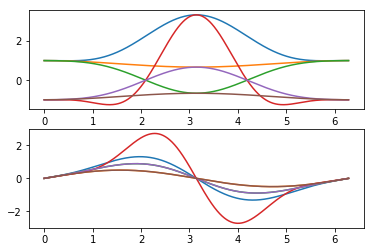

In [8]:
"""
  Plot of each composant in M (one by epsilon_i value)
"""
fig, (ax1, ax2) = plt.subplots(2,1)

for fun in wenol.func_M:
  ax1.plot(data.phi,fun(data.phi).real)
  ax2.plot(data.phi,fun(data.phi).imag)

plt.show()

En realité la valeur des différentes composantes de $M$ nous importent peu. Ce qu'il faut remarquer est la forme général de chaque composante, prenons comme exemple la composante $\epsilon_0$ :

$$
  \begin{aligned}
    \Re \left| \epsilon_0\left(\frac{11}{6} -\frac{7}{6}e^{-i\phi} + \frac{1}{3}e^{-2i\phi}\right)\right| &\leq c_0^{\Re}|\epsilon_0| \\
    \Im \left| \epsilon_0\left(\frac{11}{6} -\frac{7}{6}e^{-i\phi} + \frac{1}{3}e^{-2i\phi}\right)\right| &\leq c_0^{\Im}|\epsilon_0|
  \end{aligned}
$$

avec $c_0^{\Re|\Im}$ des constantes positives. Dans [Wang R. and Spiteri R. J. (2007)](https://doi.org/10.1137/050637868), une estimation de $c_0^{\Re}=\frac{10}{3}$ est prise comme exemple. On majore ainsi toutes les composantes en $\epsilon_i$ de $M$, on se retrouve alors avec :

$$
  \begin{aligned}
    \left|\Re\left(M(\{\epsilon_i\}_{i=0,\dots,5},\phi)\right)\right| &\leq \Gamma^{\Re}\max_{0\leq m \leq 5}|\epsilon_m| \\
    \left|\Im\left(M(\{\epsilon_i\}_{i=0,\dots,5},\phi)\right)\right| &\leq \Gamma^{\Im}\max_{0\leq m \leq 5}|\epsilon_m|
  \end{aligned}
$$

avec $\Gamma^{\Re|\Im}$ des constantes postives ne dépendant que de la taille du *stencil* considéré. Cela permet de justifier $M = \mathcal{O}(\Delta x^2)$.

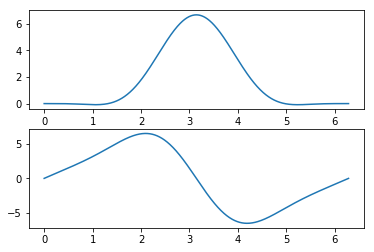

In [9]:
"""
  Plot of the sum of all composant of M (epsilon_i=1 for all i)
"""

fig, (ax1, ax2) = plt.subplots(2,1)

M_sum = reim(sum(wenol.data_M))
ax1.plot(data.phi,M_sum[0])
ax2.plot(data.phi,M_sum[1])
plt.show()

La somme de toutes les composantes en $\epsilon_i$ est facilement majorable (il ne s'agit que d'une somme de cosinus et sinus). Wang et Spiteri majore ceci par $\Gamma\max_i|\epsilon_i|$, ce qu'ils retiennent surtout est la majoration par un truc qui est proportionnel à $\epsilon_i = \mathcal{O}(\Delta x^2)$.

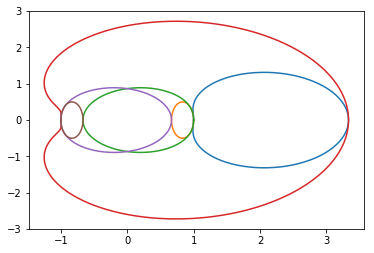

In [10]:
""" just because it's pretty: all composant of M in complex plan """
for dat in wenol.data_M:
  plt.plot(dat.real,dat.imag)
plt.show()

### 1.1.2 La partie linéaire $\tilde{z}$

$\tilde{z}$ est la partie linéaire de $\lambda^W(\phi)$ (c'est-à-dire ne dépendant pas des $\{\epsilon_j\}_{j\in[0,\cdots,5]}$. C'est la partie principale, la valeur exacte de $\lambda^W(\phi)$ peut être interprété comme la valeur de $\tilde{z} + \mathcal{O}(\Delta x^2)$.

Donc en prenant $\Delta x$ suffisamment petit, $\lambda^W(\phi) \xrightarrow{\Delta x \to 0} \tilde{z}(\phi)$.

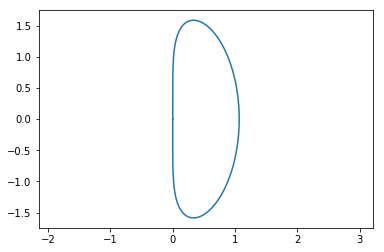

In [11]:
wenol.func_z = sp.lambdify(phi,ztilde_vN,'numpy')
wenol.data_z = wenol.func_z(data.phi)

plt.plot(*reim(wenol.data_z))
plt.axis('equal')
plt.show()

Le résultat est similaire à ce qui est présenté systématiquement comme la courbe de stabilité de la linéarisation du schéma WENO.

### 1.1.3 Étude du schéma WENO linéarisé

Le schéma WENO linéarisé, qui correspond à l'approximation des poids à :

$$
    w_i = \gamma_i
$$

c'est-à-dire en considérant que les *indicators of smootheness* valent tous 1, ce qui se justifie avec une fonction suffisamment régulière.

On perd *a priori* l'intérêt du schéma WENO, il est donc intéressant d'étudier un peu plus ce schéma.

#### 1.1.3.1 Mesure de l'ordre

On mesure numériquement l'ordre à partir du problème suivant :

$$
  \begin{cases}
    \partial_t u + \partial_x u = 0 \\
    u(t=0,x) = \cos(x)
  \end{cases}
$$

![Mesure de l'ordre numérique du schéma WENO linéarisé](img/order_WL.png)

On retrouve bien l'ordre 5 de la méthode WENO classique. 

#### 1.1.3.2 Comportement face à une discontinuité

Observons le comportement du schéma WENO linéarisé face à une discontinuité. Nous conservons ici une simple équation de transport linéaire à vitesse 1. La condition initiale est donnée par :

$$
  u(t=0,x) = \begin{cases}
    \frac{1}{2}x \quad &\text{si $x \in [0,\frac{2\pi}{3}]$}\\
    1 \quad &\text{si $x \in [\frac{2\pi}{3},\frac{4\pi}{3}]$}\\
    0 \quad &\text{sinon}
  \end{cases}
$$

La simulation s'effectuant jusqu'au temps $T_f = 2\pi$ sur le domaine spatial périodique $[0,2\pi]$, la solution exacte coïncide avec la condition initiale. La discrétisation en temps est un RK SSP(3,3).

![Oscillation du schéma WENO linéarisé en présence d'une discontinuité](img/discontinuity.png)

On remarque que le schéma WENO linéarisé oscille à proximité d'une discontinuité, le schéma WENO classique quant à lui devient plus visqueux à l'aide des poids qui permettent d'effectuer une meilleure interpolation qu'une interpolation polynomiale de degré élevé induisant localement des oscillations.

#### 1.1.3.3 Viscosité en temps long

Il n'est pas beaucoup plus ou moins visqueux que le schéma WENO classique, j'ai effectué des simulations en temps long ($T_f = 2\,018\pi$) de différentes conditions initiales et j'ai surtout observé un décalage de phase entre les schémas WENO et WENO linéarisé et la solution exacte (les schémas WENO et WENO linéarisé se déphasant de la même manière il s'agit sans doute d'une erreur du schéma en temps, il serait donc intéressant d'effectué un test avec un schéma d'ordre plus élevé en temps juste pour cette simu).

![Simulation en temps long d'un cosinus pour étudier la viscosité ou diffusion du schéma](img/diffusion.png)

Il semble en premier abord, moins diffusif que le schéma WENO classique (en effet l'amplitude en partie réelle est plus faible que la version non linéarisé, voir ci-dessous).

> TODO: supprimer les interpolations pas centrées pour vérifier ce que proposait Nicolas sur le *shift* induit par un schéma non centré
>
> Dans le premier test que j'ai fait de ça, le schéma n'était pas stable

## 1.2 WENO non linéarisé

Puisque j'effectue mes calculs à l'aide de `sympy` et qu'il est facilement d'écrire automatiquement une fonction de $\phi$ du schéma WENO complet, j'étudie l'analyse de von Neumann du schéma WENO complet non linéarisé. Il n'est pas possible de justifier ce calcul par le calcul d'une transformée de Fourrier du schéma, on peut cependant indiquer que l'on choisit en entrée une fonction se décomposant en série de Fourrier.

Le calcul fonctionne malgré la non linéarité des poids du schéma parce qu'il est toujours possible de l'exprimer comme :

$$
    \hat{u}^{n+1} = W(\phi)\hat{u}^n
$$

en effet la non linéarité des coefficients $IS_i$ permet toujours d’exhiber en facteur $(\hat{u}^n)^2$, puis un $(\hat{u}^n)^4$ dans les poids non normalisés $\alpha_i$, module que l'on simplifie lors de la normalisation des poids $w_i$ où il ne reste plus que la phase. C'est ce même phénomène qui permet de mettre en facteur la vitesse dans cette méthode lors d'une équation de transport à vitesse constante.

In [12]:
"""
  complet WENO method
"""

epsilon = sp.symbols("\\epsilon",real=True,positive=True)

IS0 = sp.Rational(13,12)*( f(-2) - 2*f(-1) + f(+0) )**2 + sp.Rational(1,4)*( f(-2) - 4*f(-1) + 3*f(+0) )**2
IS1 = sp.Rational(13,12)*( f(-1) - 2*f(+0) + f(+1) )**2 + sp.Rational(1,4)*( f(-1) - f(+1) )**2
IS2 = sp.Rational(13,12)*( f(+0) - 2*f(+1) + f(+2) )**2 + sp.Rational(1,4)*( f(+2) - 4*f(+1) + 3*f(+0) )**2

a0 = sp.Rational(1,10)*(1/(epsilon+IS0))**2
a1 = sp.Rational(6,10)*(1/(epsilon+IS1))**2
a2 = sp.Rational(3,10)*(1/(epsilon+IS2))**2

s = a0 + a1 + a2
w0 = a0 / s
w1 = a1 / s
w2 = a2 / s

fjp12 = ( w0*( sp.Rational(2,6)*f(-2) - sp.Rational(7,6)*f(-1) + sp.Rational(11,6)*f(+0) )
        + w1*(-sp.Rational(1,6)*f(-1) + sp.Rational(5,6)*f(+0) +  sp.Rational(2,6)*f(+1) )
        + w2*( sp.Rational(2,6)*f(+0) + sp.Rational(5,6)*f(+1) -  sp.Rational(1,6)*f(+2) ) )
# on définit fjm12 comme étant fjp12 où on substitut f(j) par f(j-1)
fjm12 = fjp12.subs(symbols_to(f_stencil, lambda j,_:f(j-1)),simultaneous=True)

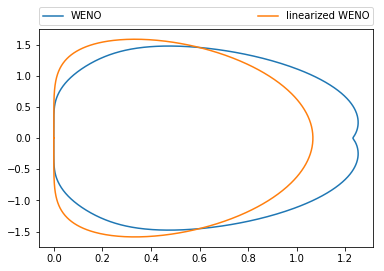

In [13]:
weno = Data()
weno.func = sp.lambdify(phi,(fjp12 - fjm12).subs(symbols_to_vonNeumann(f_stencil)).subs(epsilon,10**(-6)),'numpy')
weno.data = weno.func(data.phi)

plt.plot(*reim(weno.data),label="WENO")
plt.plot(*reim(wenol.data_z),label="linearized WENO")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102),loc=3,ncol=2, mode="expand",borderaxespad=0.)
plt.show()

On remarque une divergence dans les résultats. Une précédente étude avait montré que la CFL du couple RK3-WENO5 était atteinte à la base de l'*œuf* que forme la linéarisation du schéma WENO. La version non linéarisée étant moins large à la base, la CFL semble pouvoir être plus importante.

> Il est intéressant à noter qu'un transport pur s'exprime avec l'axe imaginaire, la partie réelle traduit un phénomène de diffusion. On remarque que le schéma WENO linéarisé est donc moins diffusif que sa version standard. Ceci s'explique par la construction du schéma WENO qui par le biais de ses poids, diffuse à l'approche d'une discontinuité au lieu d'osciller. Une confirmation de se résultat a été apporté numériquement par des tests sur le schémas WENO linéarisé, celui-ci oscille légèrement à l'approche d'une discontinuité au lieu de diffuser. Diffusion observée lors de la comparaison des deux schémas en temps long.

# 2. Présentation des schémas compacts

Une autre approche avait été lancé au début du stage, dans la recherche de schémas d'ordre élevé, celle des schémas compacts. Ceux-ci sont oscillants, et je n'ai jamais réussi à les faire fonctionner dans le cadre d'une vitesse négative (il s'agit sans doute d'une symétrie similaire à celle effectuée dans le schéma WENO, symétrie pour laquelle j'ai toujours bêtement appliqué les formules).

On ne va pas présenté de manière exhaustive la famille des schémas compacts, de plus on ne s'intéressera ici qu'au schéma d'ordre 5 (ordre identique à celui du schéma WENO5 précédemment présenté). Il s'agit d'une interpolation polynomiale lagrangienne de degré 5. Comme toute interpolation polynomiale de degré élevé, celle-ci présente le risque d'osciller (c'est pour prévenir ce caractère que le schéma WENO fait intervenir des poids non linéaires).

Pour plus d'information j'invite le lecteur à lire [Després B. (2009)](https://doi.org/10.1137/080734571).

On souhaite résoudre un problème du type :

$$
  \partial_t u + v\partial_x u = 0,\quad v>0
$$

nous prendrons $v=1$. Le nombre de Courant est défini par $\nu = v\frac{\Delta t}{\Delta x}$.

Le schéma d'ordre 5 qui nous intéresse possède un flux qui s'écrit comme :

$$
  \begin{aligned}
    u_{j+\frac{1}{2}} = u^n_{j+2} + \frac{\nu+3}{2}(u^n_{j+1}-u^n_{j+2}) + \frac{(2+\nu)(1+\nu)}{6}(u^n_j - 2u^n_{j+1} + u^n_{j+2}) + \frac{(2+\nu)(1+\nu)(\nu-1)}{24}(u^n_{j-1} - 3u^n_{j} + 3u^n_{j+1} - u^n_{j+2}) + \frac{(2+\nu)(1+\nu)(\nu-1)(\nu-2)}{120}(u^n_{j-2} - 4u^n_{j-1} + 6u^n_{j} - 4u^n_{j+1} + u^n_{j+2})
  \end{aligned}
$$

On obtient, après analyse de von Neumann, un flux qui s'écrit comme un polynôme de $\nu = \frac{\Delta t}{\Delta x}$ et de $e^{i\phi}$. Il devient par conséquent difficile de tracer la courbe du coefficient d'amplification du schéma compact, à la manière du schéma WENO. Par conséquent l'étude du schéma compact s'arrête là.

In [14]:
nu = sp.symbols("\\nu") #dt/dx
ujp12 = ( f(-2) + (nu+3)/2*(f(+1)-f(+2)) + (2+nu)*(1+nu)/6*(f(+0) - 2*f(+1) + f(+2))
        + (2+nu)*(1+nu)*(nu-1)/24*(f(-1) - 3*f(+0) + 3*f(+1) - f(+2))
        + (2+nu)*(1+nu)*(nu-1)*(nu-2)/120*(f(-2) - 4*f(-1) + 6*f(+0) - 4*f(+1) + f(+2)) )
ujm12 = ujp12.subs(symbols_to(f_stencil, lambda j,_:f(j-1)),simultaneous=True)

(ujp12-ujm12).subs(symbols_to_vonNeumann(f_stencil)).expand().collect(nu)

     ⎛ 2⋅ⅈ⋅\phi    ⅈ⋅\phi         -ⅈ⋅\phi    -2⋅ⅈ⋅\phi    -3⋅ⅈ⋅\phi⎞        ⎛ 
   4 ⎜ℯ           ℯ         1    ℯ          ℯ            ℯ         ⎟      3 ⎜ 
\nu ⋅⎜───────── - ─────── + ── - ──────── + ────────── - ──────────⎟ + \nu ⋅⎜-
     ⎝   120         24     12      12          24          120    ⎠        ⎝ 

  2⋅ⅈ⋅\phi    ⅈ⋅\phi        -ⅈ⋅\phi    -2⋅ⅈ⋅\phi⎞        ⎛ 2⋅ⅈ⋅\phi    ⅈ⋅\phi 
 ℯ           ℯ         1   ℯ          ℯ         ⎟      2 ⎜ℯ           ℯ       
 ───────── + ─────── - ─ + ──────── - ──────────⎟ + \nu ⋅⎜───────── + ─────── 
     24         6      4      6           24    ⎠        ⎝    24         24   

          -ⅈ⋅\phi      -2⋅ⅈ⋅\phi    -3⋅ⅈ⋅\phi⎞       ⎛ 2⋅ⅈ⋅\phi      ⅈ⋅\phi   
  5    7⋅ℯ          7⋅ℯ            ℯ         ⎟       ⎜ℯ           2⋅ℯ         
- ── + ────────── - ──────────── + ──────────⎟ + \nu⋅⎜───────── - ───────── + 
  12       12            24            24    ⎠       ⎝    24          3       

       -ⅈ⋅\phi    -2⋅ⅈ⋅\phi⎞       2⋅ⅈ⋅\phi      



Le problème est similaire à celui de l'étude du schéma IFRK, c'est-à-dire que l'on obtient un polynôme à 2 variables. L'idée est alors de tester de tracer une fonction de $\phi$ pour différentes valeurs de $\nu$.

200


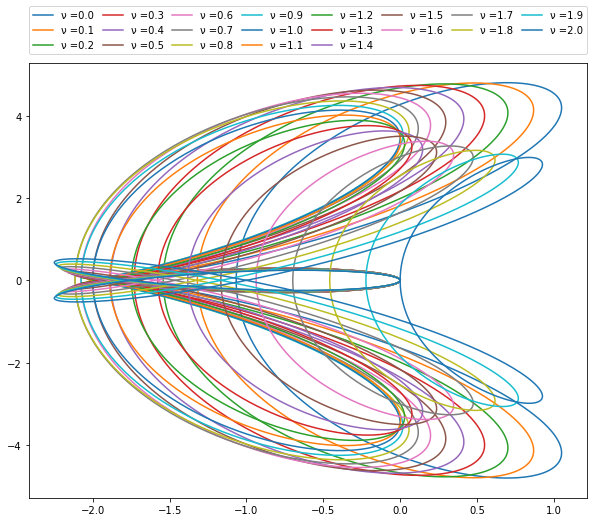

In [15]:
compact = Data()
compact.func = []
compact.data = []

save_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [10, 8]
for i in range(0,201,10):
  nu_num = i/100.
  print(i,end="\r")
  fun = sp.lambdify(phi,(ujp12-ujm12).subs(symbols_to_vonNeumann(f_stencil)).expand().subs(nu,nu_num),'numpy')
  compact.func.append(fun)
  dat = fun(data.phi)
  compact.data.append(dat)
  plt.plot(*reim(-dat),label="ν ={}".format(nu_num))
print()
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102),loc=3,ncol=8, mode="expand",borderaxespad=0.)
plt.show()
plt.rcParams['figure.figsize'] = save_figsize

# 3. Schémas RK

Les schémas Runge-Kutta sont souvent utilisés dans le domaine des EDP pour résoudre la discrétisation en temps, conforme à cette tradition c'est ce que nous allons effectuer. Nous cherchons quel est l'ordre minimale $N$ pour stabiliser le couple RK$N$-WENO5, ou celui qui permettra d'obtenir la plus grande CFL avec le minimum de coût numérique.

On s'intéresse ici au polynôme caractéristique d'un schéma RK. On sait que le polynôme caractéristique d'un schéma RK$N$ est une troncature de la série entière de l'exponentielle (auquel peut s'ajouter des termes de degré plus élevé si le nombre d'étage $s$ est supérieur à l'ordre de la méthode $N$), donc de la forme :

$$
  p_N(z) = \sum_{n=0}^N \frac{z^n}{n!}
$$

Il est ensuite nécessaire de tracer la courbe d'équation $|p_N(z)| = 1$, pour cela Miguel m'a proposé de résoudre dans un premier temps l'équation :

$$
  p_N(z) = e^{i\theta}
$$

à $\theta$ fixé, on a ainsi $N$ solutions $(b_0(\theta),\dots,b_N(\theta))$. Puis ensuite faire varier $\theta \in [0,2\pi[$. On obtient ainsi $N$ courbes paramétriques que l'on peut tracer sans trop de problèmes.

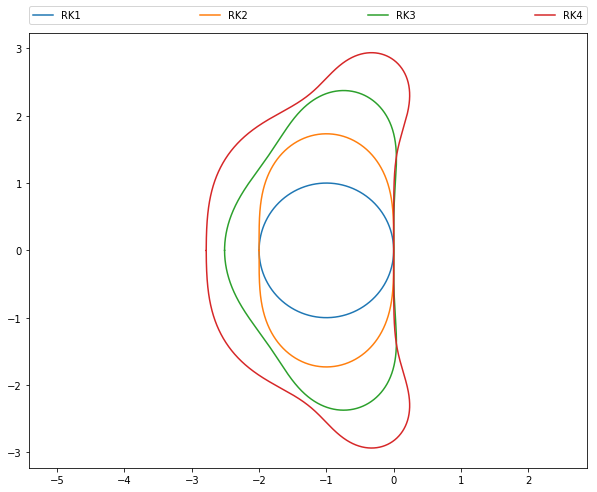

In [16]:
z = sp.symbols("z",complex=True)
theta = sp.symbols("\\theta",real=True)

import math

def poly_carac(N):
  return sum([ sp.Rational(1,(math.factorial(n)))*z**n for n in range(N+1) ])

def b(N):
  p = poly_carac(N)
  bset = sp.solveset(sp.Eq(p,sp.exp(I*theta)),z)
  
  bcurve = []
  for b in [ sp.lambdify(theta,b,'numpy') for b in bset ] :
    tmp = b(data.phi)
    bcurve.extend(tmp.tolist())
  return np.array(sorted(bcurve,key=lambda z:np.angle(z+1)))


b1 = b(1)
b2 = b(2)
b3 = b(3)
b4 = b(4)

save_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(*reim(b1),label="RK1")
plt.plot(*reim(b2),label="RK2")
plt.plot(*reim(b3),label="RK3")
plt.plot(*reim(b4),label="RK4")
plt.axis('equal')
plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=3,ncol=4,mode="expand",borderaxespad=0.)
plt.show()
plt.rcParams['figure.figsize'] = save_figsize

On retrouve bien les mêmes profiles que dans la littératures. L'obtention de la courbe nécessite l'obtention d'un polynôme de degré $N$, cette méthode n'est donc plus envisageable sans évaluation numérique aux ordres supérieurs.

## 3.1 Petit test en 3D

Il est relativement simple d'évaluer pour une série de point d'une grille la valeur de $|p_N(z_{j,k})|$ avec $z$ définit par :

$$
  z_{j,k} = j\Delta x + ik\Delta y
$$

Vu la facilité de la tâche il est relativement simple de répéter l'opération pour différents polynômes caractéristiques $p_N$. Le travail a été effectué pour $N=2,\dots,7$ (sans la moindre analyse des résultats, et avec une grille sans doute très mauvaise ainsi qu'un domaine qui ne permet pas de voir tout le domaine de RK7). On trace ainsi facilement :

$$
  \{z\in\mathbb{C},|p_N(z)| \leq 1\}
$$

Pour $N=3$, le cas qui nous intéresse, on obtient ainsi :

![Module de $p_3(z)$](img/rkdat/rk3.png)

Nous évaluons ici le polynôme en tous les points de la grille, la méthode est la seule pour déterminer la frontière $|p_N(z)| = 1$, par conséquent l'étude de CFL à des degrés supérieurs s'effectue nécessairement numériquement.

## 3.2 Exploration pour les ordres supérieurs

Je n'arrive pas à trouver avec `sympy` par la même méthode RK5 (problème d'absence de formule analytique pour les racines pour les polynôme de degré supérieur ou égal à 5). Pour obtenir l'ensemble :

$$
  b_5 = \{ z\in\mathbb{C},|p_5(z)| = 1 \}
$$

je dois explorer une autre méthode.

In [17]:
p5 = poly_carac(5)
b5set = sp.solveset(p5-sp.exp(I*theta),z)
b5set

⎧              5    4    3    2                        ⎫
⎪             z    z    z    z         ⅈ⋅\theta        ⎪
⎨z | z ∊ ℂ ∧ ─── + ── + ── + ── + z - ℯ         + 1 = 0⎬
⎪            120   24   6    2                         ⎪
⎩                                                      ⎭

La seule méthode généralisable est l'évaluation numérique du polynôme sur une grille. Une étude un peu plus approfondie permettrait de se donner une idée des points de la grille à évaluer (le domaine de stabilité d'une méthode RK$N+1$ contient approximativement celui de RK$N$ par exemple, le domaine s'étend beaucoup moins du côté de la partie réelle positive).

Je ne sais pas exactement comment fonctionne la fonction `plt.contour` qui permet effectivement de faire cela, mais elle réussit avec une grille relativement grossière à obtenir un coutour assez précis, en un temps relativement court. Une tentative d'écriture d'une fonction similaire en évaluant la fonction en tous les points d'un maillage fut un échec aussi bien au niveau de la précision que du temps de calcul.

In [18]:
import matplotlib.colors as mcolors # for mcolors.TABLEAU_COLORS
palette = list(mcolors.TABLEAU_COLORS)

def contour ( expr , z , Ir , Ii , **kwargs):
  x,y = sp.symbols("x y",real=True)
  f = sp.lambdify((x, y), expr.subs(z,x+I*y),'numpy')
  
  a = np.linspace(*Ir)
  b = np.linspace(*Ii)
  X, Y = np.meshgrid(a, b)
  return plt.contour(X,Y, f(X,Y),**kwargs)

Ce qui fut découvert relativement tard est la possibilité à partir de cette fonction de récupérer les points tracés à l'aide de l'attribut `allsegs` de la classe `matplotlib.contour.QuadContourSet`

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/ma/core.py:2788: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


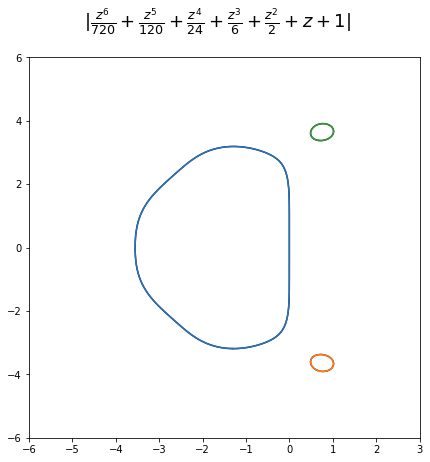

105 927 105


In [19]:
R = sp.Abs(poly_carac(6))

save_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [7, 7]

dat0 = contour(R,z,(-6.,3.,500),(-6.,6.,500), levels=[1.]).allsegs

plt.suptitle("$"+sp.latex(R)+"$",fontsize=18)
plt.plot(dat0[0][1][:,0],dat0[0][1][:,1])
plt.plot(dat0[0][0][:,0],dat0[0][0][:,1])
plt.plot(dat0[0][2][:,0],dat0[0][2][:,1])
plt.show()

plt.rcParams['figure.figsize'] = save_figsize

# comparaison du nombre de point dans la frontière de chaque sous domaine
print(len(dat0[0][0][:]),len(dat0[0][1][:]),len(dat0[0][2][:]))

Pour un domaine non connexe (comme c'est le cas pour RK6) on obtient une liste de tableaux de points (en coordonnées cartésiennes). Il est nécessaire d'identifier le tableau le plus long pour obtenir *a priori* le domaine central.

On peut ainsi investiguer les ordres supérieurs.

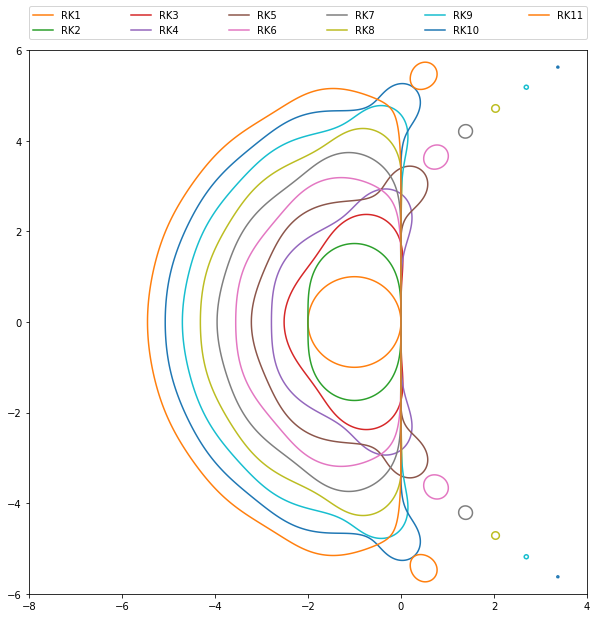

In [20]:
save_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [10, 10]

for n in range(1,12):
  R = sp.Abs(poly_carac(n))
  contour(R,z,(-8.,4.,500),(-6.,6.,500), levels=[1.],colors=palette[n%len(palette)])
  plt.plot([0],[0],label="RK{}".format(n),color=palette[n%len(palette)]) # astuce pour avoir une légende
plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=3,ncol=6,mode="expand",borderaxespad=0.)
plt.show()

plt.rcParams['figure.figsize'] = save_figsize

L'étude des domaines de stabilité pour des méthdes de Runge-Kutta d'ordre 1 à 4 reste plus simple (et suffit pour ce que l'on souhaite faire), par conséquent l'étude des ordres plus élevés ne sera pas au coeur de la suite et servira plus de test pour valider l'automatisation d'un calcul.

## 3.3 Polynôme caractéristique pour d'autres méthodes

### 3.3.1 Obtention du polynôme caractéristique depuis un schéma numérique

Le calcul effectué ne s'applique que pour un RK$N$ à $N$ étages. Considérons maintenant un RK$N$ à $s$ étages ($s>N$). Il est nécessaire de calculer son polynôme caractéristique.

> Il s'agit d'un travail préliminaire pour l'obtention de polynôme caractéristique d'un IFRK (*integrating factor Runge-Kutta method*) qui est une famille de schémas introduisant une exponentielle pour résoudre une équation du type : $$
        \frac{\mathrm{d}u}{\mathrm{d}t} = Lu + N(u)
    $$

Pour obtenir un polynôme caractéristique il est nécessaire de linéariser le problème en passant en complexe. Ainsi pour un problème du type :

$$
  \frac{\mathrm{d}u}{\mathrm{d}t} = L(u)
$$

on effectue la substitution :

* $L(u) \rightarrow \lambda u$ (on linéarise $L$ sur le plan complexe à l'aide d'une variable $\lambda$, dans notre cas $\lambda$ représente le coefficient d'amplification de notre méthode WENO)
* $\lambda \Delta t \rightarrow z$ (on veut étudier le coefficient d'amplification donné par le produit $\lambda \Delta t$)

Nous étudions ainsi un schéma RK3 à 4 étages :

$$
  \begin{aligned}
    u^{(1)} &= u^n + \frac{1}{2}\Delta t L(u^n,t^n) \\
    u^{(2)} &= u^{(1)} + \frac{1}{2}\Delta t L(u^{(1)},t^n+\frac{1}{2}\Delta t) \\
    u^{(3)} &= \frac{2}{3}u^n + \frac{1}{3}u^{(2)} + \frac{1}{6}\Delta t L(u^{(2)},t^n+\Delta t) \\
    u^{n+1} &= u^{(3)} + \frac{1}{2}\Delta t L(u^{(3)},t^n+\frac{1}{2}\Delta t)
  \end{aligned}
$$

> Il est à noter qu'une méthode à $s$ étages donne un polynôme de degré $s$, par conséquent il n'est pas envisageable dans l'état actuel d'étudier des schémas en temps de degré supérieur à 4 pour les raisons expliqués sur la résolution de polynôme de degré 5.

In [21]:
un = sp.symbols("u_n")
dt = sp.symbols("\\Delta\\ t",real=True)
lamb = sp.symbols("\\lambda",complex=True)
z = sp.symbols("z",complex=True)

def L(u):
  return lamb*u

In [22]:
"""
Test de la procédure sur différents RK
RK3 Shu-Osher
"""
u1 = un + dt*L(un)
u2 = sp.Rational(3,4)*un + sp.Rational(1,4)*u1 + sp.Rational(1,4)*dt*L(u1)
un1 = sp.Rational(1,3)*un + sp.Rational(2,3)*u2 + sp.Rational(2,3)*dt*L(u2)

un1.subs(lamb*dt,z).expand().collect(un).collect(z)

   ⎛ 3    2        ⎞
   ⎜z    z         ⎟
uₙ⋅⎜── + ── + z + 1⎟
   ⎝6    2         ⎠

On retrouve bien le polynôme caractéristique de SPPRK(3,3).

In [23]:
""" RK3 à 4 étages """
u1 = un + sp.Rational(1,2)*dt*L(un)
u2 = u1 + sp.Rational(1,2)*dt*L(u1)
u3 = sp.Rational(2,3)*un + sp.Rational(1,3)*u2 + sp.Rational(1,6)*dt*L(u2)
un1 = u3 + sp.Rational(1,2)*dt*L(u3)

un1.subs(lamb*dt,z).expand().collect(un).collect(z)

   ⎛ 4    3    2        ⎞
   ⎜z    z    z         ⎟
uₙ⋅⎜── + ── + ── + z + 1⎟
   ⎝48   6    2         ⎠

On peut aussi (juste pour l'illustration) effectuer le même travail sur un schéma RK6 à 7 étages, obtenu dans [Luther H. A. (1968)](https://doi.org/10.2307/2004675).

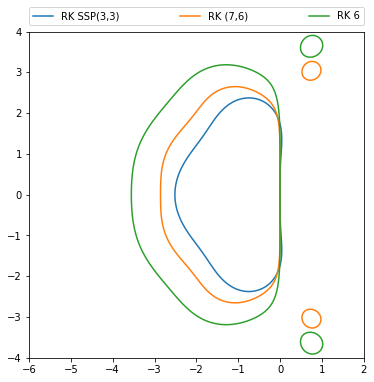

⎛    7      6     5    4    3    2            7      6     5    4    3    2   
⎜   z      z     z    z    z    z            z      z     z    z    z    z    
⎜- ──── + ─── + ─── + ── + ── + ── + z + 1, ──── + ─── + ─── + ── + ── + ── + 
⎝  2160   720   120   24   6    2           5040   720   120   24   6    2    

     ⎞
     ⎟
z + 1⎟
     ⎠

In [24]:
""" RK6 à 7 étages [Luther H. A. (1968)] """
# ce schéma n'est pas utilisé par la suite
nu = sp.symbols("\\nu")
s21 = sp.sqrt(21)

k1 = dt*L(un)
k2 = dt*L(un+nu*k1)
k3 = dt*L(un+ ((4*nu-1)*k1+k2)/(8*nu) )
k4 = dt*L(un+ ((10*nu-2)*k1 + 2*k2 + 8*nu*k3)/(27*nu) )
k5 = dt*L(un+ (-((77*nu-56)+(17*nu-8)*s21)*k1
              -8*(7+s21)*k2 + 48*(7+s21)*nu*k3
              -3*(21+s21)*nu*k4)/(392*nu) )
k6 = dt*L(un+ (-5*((287*nu-56)-(59*nu-8)*s21)*k1
              - 40*(7-s21)*k2 + 320*s21*nu*k3 + 3*(21-121*s21)*nu*k4
              + 392*(6-s21)*nu*k5)/(1960*nu) )
k7 = dt*L(un+ ( 15*((30*nu-8)-(7*nu*s21))*k1 + 120*k2
              - 40*(5+7*s21)*nu*k3 + 63*(2+3*s21)*nu*k4
              - 14*(49-9*s21)*nu*k5 + 70*(7+s21)*nu*k6)/(180*nu) )

un1_rk6 = un + (9*k1 + 64*k3 + 49*k5 + 49*k6 + 9*k7)/180
prk6_7 = un1_rk6.subs(lamb*dt,z).expand().collect(un)/un.collect(z)

# domaine de stabilité de cette méthode
save_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [6, 6]

contour(sp.Abs(poly_carac(3)),z,(-6.,2.,500),(-4.,4.,500), levels=[1.],colors=palette[0]); plt.plot([0],[0],label="RK SSP(3,3)",color=palette[0])
contour(sp.Abs(prk6_7),z,(-6.,2.,500),(-4.,4.,500), levels=[1.],colors=palette[1]); plt.plot([0],[0],label="RK (7,6)",color=palette[1])
contour(sp.Abs(poly_carac(6)),z,(-6.,2.,500),(-4.,4.,500), levels=[1.],colors=palette[2]); plt.plot([0],[0],label="RK 6",color=palette[2])

plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=3,ncol=3,mode="expand",borderaxespad=0.)
plt.show()

plt.rcParams['figure.figsize'] = save_figsize

(prk6_7,poly_carac(7))

Il est maintenant intéressant d'étudier le domaine de stabilité de ce schéma RK3 à 4 étages.

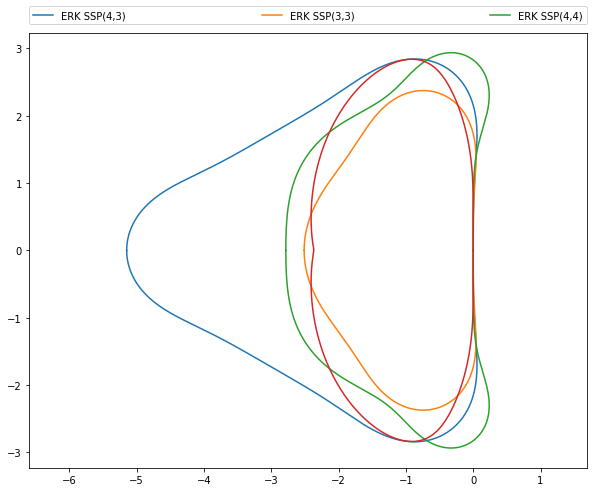

In [25]:
p = un1.subs(lamb*dt,z).expand().collect(un).collect(z)/un

def b_poly(p):
  bset = sp.solveset(sp.Eq(p,sp.exp(I*theta)),z)
  bcurve = []
  for (i,b) in enumerate([ sp.lambdify(theta,b,'numpy') for b in bset ]) :
    bcurve.extend(b(data.phi))
  return np.array(sorted(bcurve,key=lambda z:np.angle(z+1)))

b34 = b_poly(p)
b3  = b_poly(poly_carac(3)) # juste pour exemple pour montrer que l'équivalence des fonctions

save_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(*reim(b34),label="ERK SSP(4,3)")
plt.plot(*reim(b3),label="ERK SSP(3,3)")
plt.plot(*reim(b4),label="ERK SSP(4,4)")
plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=3,ncol=3,mode="expand",borderaxespad=0.)
plt.plot(*reim(-1.923*weno.data),label="WENO") # WENO maximisé par la CFL que l'on calculera après
plt.axis('equal')
plt.show()
plt.rcParams['figure.figsize'] = save_figsize

### 3.3.2 Obtention du polynôme caractéristique depuis le tableau de Butcher

Parce qu'il est moins facile d'écrire un tableau de Butcher qu'un schéma numérique, je m'étais contenté d'écrire une méthode d'obtention du polynôme caractéristique à partir du schéma et non du tableau de Butcher.

Pour le moment la fonction que je propose se limite aux cas d'ERK (*Explicit Runge-Kuta method*). Je n'ai pas encore réfléchi à l'obtention du polynôme caractéristique dans le cas par exemple d'une méthode DIRK (*Diagonal Implicit Runger-Kutta method*).

La fonction `poly_butcher` fonctionne pour un tableau de Butcher écrit comme suit :

$$
  \begin{array}{c|c}
    \begin{matrix}
      a_{11} & \cdots & a_{1s} \\
      \vdots & \ddots & \vdots \\
      a_{s1} & \cdots & a_{ss}
    \end{matrix} & \begin{matrix} b_1 \\ \vdots \\ b_s \end{matrix} \\ \hline
    \begin{matrix}c_1 & \cdots & c_s \end{matrix} & \\
  \end{array}
$$

Le schéma qui en résulte est de la forme :

$$
  \begin{aligned}
    u^{(i)} &= u^n + \Delta t \sum_j a_{ij} L(t^n+b_j\Delta t , u^{(j)}) \\
    u^{n+1} &= u^n + \Delta t \sum_i c_i L(t^n+b_i\Delta t , u^{(i)})
  \end{aligned}
$$

Ce schéma est explicite si et seulement si la matrice $A$ est triangulaire strictement inférieure. On ne précisera pas ici les propriétés liant $A$, $b$ et $c$ pour déterminer l'ordre de la méthode, son caractère SSP ou autre.

Dans l'obtention du polynôme caractéristique du schéma, le vecteur $b$ n'est pas nécessaire puisqu'on linéarise l'opération $L(t^n+b_j\Delta t , u^{(j)})$ par $\lambda u^{(j)}$.

In [26]:
def poly_butcher( A , c , b=0 ):
  """
    /!\ fonction ne fonctionnant que pour des schémas explicites
    pour des méthodes DIRK, revoir cette fonction en créeant un tableau
    de symbols u_s et en cherchant comment expliciter la diagonale implicite
  """
  r = range(len(c))
  u_s = [ 0 for i in r ]
  for i in r:
    u_s[i] = 1 + dt*sum([ A[i][j]*lamb*u_s[j] for j in r ])
  un1 = 1 + dt*sum([ c[j]*lamb*u_s[j] for j in r ])
  return un1.expand().collect(z).subs(dt*lamb,z).collect(z)

In [27]:
""" vérification sur RK3 """
A = [[0,0,0],[1,0,0],[sp.Rational(1,4),sp.Rational(1,4),0]]
b = [0,1,sp.Rational(1,2)]
c = [sp.Rational(1,6),sp.Rational(1,6),sp.Rational(2,3)]

poly_butcher(A=A,b=b,c=c)

 3    2        
z    z         
── + ── + z + 1
6    2         

In [28]:
""" vérification sur RK4 """
A = [[ 0               , 0               , 0 , 0 ] ,
     [ sp.Rational(1,2), 0               , 0 , 0 ] ,
     [ 0               , sp.Rational(1,2), 0 , 0 ] ,
     [ 0               , 0               , 1 , 0 ]]
b = [0,sp.Rational(1,2),sp.Rational(1,2),1]
c = [sp.Rational(1,6),sp.Rational(1,3),sp.Rational(1,3),sp.Rational(1,6)]

poly_butcher(A=A,b=b,c=c)

 4    3    2        
z    z    z         
── + ── + ── + z + 1
24   6    2         

In [29]:
""" test sur RK NSSP(5,3) [Wang R. and Spiteri R. J. (2007)] """
A = [[ 0 , 0 , 0 , 0 , 0 ]                 ,
     [ sp.Rational(1,7)  , 0 , 0 , 0 , 0 ] ,
     [ 0 , sp.Rational(3,16) , 0 , 0 , 0 ] ,
     [ 0 , 0 , sp.Rational(1,3)  , 0 , 0 ] ,
     [ 0 , 0 , 0 , sp.Rational(2,3)  , 0 ]]
b = [0,sp.Rational(1,7),sp.Rational(3,16),sp.Rational(1,3),sp.Rational(2,3)]
c = [sp.Rational(1,4),0,0,0,sp.Rational(3,4)]

prk3_5 = poly_butcher(A=A,b=b,c=c)
prk3_5

  5    4    3    2        
 z    z    z    z         
─── + ── + ── + ── + z + 1
224   32   6    2         

In [30]:
""" test sur RK 6 [Banks J. W. et all (2019)] """
A = [[  0 ,  0 , 0 , 0 , 0 , 0 , 0 , 0 ] ,
     [  sp.Rational(1,9)             ,  0                         ,  0                          ,  0                           ,  0                      , 0                     , 0                  , 0 ] ,
     [  sp.Rational(1,24)            ,  sp.Rational(1,8)          ,  0                          ,  0                           ,  0                      , 0                     , 0                  , 0 ] ,
     [  sp.Rational(1,6)             , -sp.Rational(1,2)          ,  sp.Rational(2,3)           ,  0                           ,  0                      , 0                     , 0                  , 0 ] ,
     [  sp.Rational(935,2536)        , -sp.Rational(2781,2536)    ,  sp.Rational(309,317)       ,  sp.Rational(321,1268)       ,  0                      , 0                     , 0                  , 0 ] ,
     [ -sp.Rational(12710,951)       ,  sp.Rational(8287,317)     , -sp.Rational(40,317)        , -sp.Rational(6335,317)       ,  8                      , 0                     , 0                  , 0 ] ,
     [  sp.Rational(5840285,3104064) , -sp.Rational(7019,2536)    , -sp.Rational(52213,86224)   ,  sp.Rational(1278709,517344) , -sp.Rational(433,2448)  , sp.Rational(33,1088)  , 0                  , 0 ] , 
     [ -sp.Rational(5101675,1767592) ,  sp.Rational(112077,25994) ,  sp.Rational(334875,441898) , -sp.Rational(973617,883796)  , -sp.Rational(1421,1394) , sp.Rational(333,5576) , sp.Rational(36,41) , 0 ]]

c =  [  sp.Rational(41,840)          ,  0                         ,  sp.Rational(9,35)          ,  sp.Rational(9,280)          ,  sp.Rational(34,105)    , sp.Rational(9,280)    , sp.Rational(9,35)  , sp.Rational(41,840) ]

prk6_8 = poly_butcher(A=A,c=c)
( prk6_8 , poly_carac(8) )

⎛      8           7     6     5    4    3    2             8      7      6   
⎜1177⋅z     18713⋅z     z     z    z    z    z             z      z      z    
⎜──────── + ──────── + ─── + ─── + ── + ── + ── + z + 1, ───── + ──── + ─── + 
⎝48285440   81481680   720   120   24   6    2           40320   5040   720   

  5    4    3    2        ⎞
 z    z    z    z         ⎟
─── + ── + ── + ── + z + 1⎟
120   24   6    2         ⎠

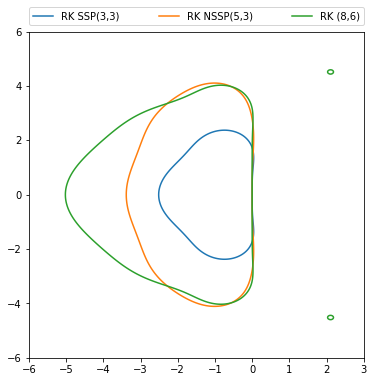

In [31]:
save_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [6, 6]

contour(sp.Abs(poly_carac(3)),z,(-6.,3.,500),(-6.,6.,500), levels=[1.],colors=palette[0]); plt.plot([0],[0],label="RK SSP(3,3)",color=palette[0])
contour(sp.Abs(prk3_5),z,(-6.,3.,500),(-6.,6.,500), levels=[1.],colors=palette[1]); plt.plot([0],[0],label="RK NSSP(5,3)",color=palette[1])
contour(sp.Abs(prk6_8),z,(-6.,3.,500),(-6.,6.,500), levels=[1.],colors=palette[2]); plt.plot([0],[0],label="RK (8,6)",color=palette[2])

plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=3,ncol=3,mode="expand",borderaxespad=0.)
plt.show()

plt.rcParams['figure.figsize'] = save_figsize

On peut aussi souhaiter effectuer l'inverse, à partir d'un polynôme caractéristique obtenu en maximisant un certain coefficient sur un RK3 à 4 étages, chercher à obtenir le schéma ou le tableau de Butcher associé. Pour cela on calcule le polynôme caractéristique d'une matrice $A=(a_{ij})_{ij}$ et un vecteur $c = (c_j)_j$, et on cherche à obtenir les relations d'ordre.

In [32]:
a_mat = sp.symbols('a_:3:3')

A = np.array(a_mat).reshape((3,3))
b = sp.symbols('b:3')
c = sp.symbols('c:3')
pb = sp.Poly(poly_butcher(A,c), z)
pc = sp.Poly(poly_carac(3), z)
[sp.Eq(cb,cc) for (cb,cc) in zip( pb.coeffs() , pc.coeffs() )]


[a₁₀⋅a₂₁⋅c₂ = 1/6, a₁₀⋅c₁ + a₂₀⋅c₂ + a₂₁⋅c₂ = 1/2, c₀ + c₁ + c₂ = 1, True]

Maintenant il faut savoir quoi faire de ces relations d'ordre. On peut par exemple contraindre la forme de la matrice $A$ (par exemple diagonale inférieure, comme dans RK NSSP(5,3)), la positivité de certains coefficients, d'autres relations pour assurer un caractère SSP ou non, etc.

> Il est normal que le résultat donné ici ne donne qu'une relation faisant intervenir $a_{10}$, $a_{20}$ et $a_{21}$ puisque pour le moment la fonction `poly_butcher` ne fonctionne qu'avec une méthode RK explicite. L'étude de DIRK2 par exemple nécessiterait une amélioration de la fonction.

## 3.4 Recherche du meilleur domaine de stabilité

Nicolas est intéressé par effectuer une étude un peu inverse, c'est-à-dire trouver le meilleur coefficient $\alpha$ tel que le polynôme caractéristique :

$$
  \alpha z^4 + \frac{z^3}{6} + \frac{z^2}{2} + z + 1
$$

ait le plus grand domaine de stabilité (en particulier sur l'axe imaginaire, pour exprimer la stabilité d'un schéma non diffusif). C'est à dire ajouter un étage sur une méthode RK3 existante, telle que celle-ci obtienne une meilleure stabilité.

In [33]:
a = sp.symbols("\\alpha")
p = a*z**4 + poly_carac(3)

56


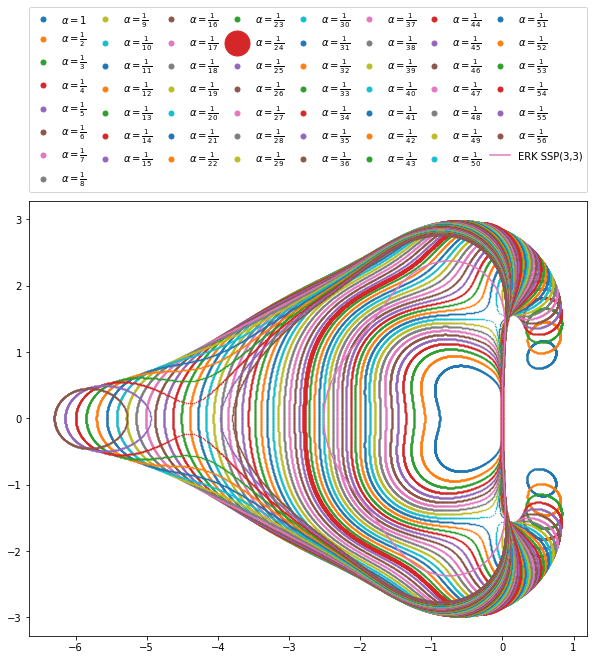

In [34]:
save_figsize = plt.rcParams['figure.figsize']
msize = 1
plt.rcParams['figure.figsize'] = [10, 8]
for n in range(1,57,1):
  print(n,end="\r")
  if n == 24 :
    msize = 5
  else:
    msize = 1
  bn = b_poly(p.subs(a,sp.Rational(1,n)))
  plt.plot(*reim(bn),'.',markersize=msize,label="$\\alpha = {}$".format(sp.latex(sp.Rational(1,n))))
print()
plt.plot(*reim(b3),label="ERK SSP(3,3)")
plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=3,ncol=8,mode="expand",borderaxespad=0.,markerscale=10)
plt.show()
plt.rcParams['figure.figsize'] = save_figsize

Il s'agit là que d'une étude prospective, pour estimer la faisabilité à Nicolas d'une telle étude de manière quasi-automatisée. On semble remarquer que le schéma le plus *large* sur l'axe imaginaire correspond à RK4 (coefficient $\frac{1}{24}$ correspondant à la courbe en rouge un peu plus grasse).

16


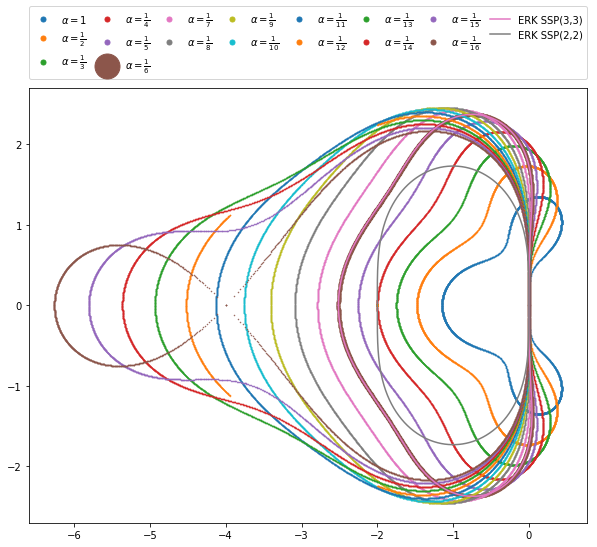

In [35]:
"""
  même étude pour RK2 à 3 étages
"""

a = sp.symbols("\\alpha",real=True,positive=True)
p = a*z**3 + poly_carac(2)

save_figsize = plt.rcParams['figure.figsize']
msize = 1
plt.rcParams['figure.figsize'] = [10, 8]
for n in range(1,17,1):
  print(n,end="\r")
  if n == 6 :
    msize = 5
  else:
    msize = 1
  bn = b_poly(p.subs(a,sp.Rational(1,n)))
  plt.plot(*reim(bn),'.',markersize=msize,label="$\\alpha = {}$".format(sp.latex(sp.Rational(1,n))))
print()

plt.plot(*reim(b3),label="ERK SSP(3,3)")
plt.plot(*reim(b2),label="ERK SSP(2,2)")

plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=4,ncol=8,mode="expand",borderaxespad=0.,markerscale=10)
plt.show()
plt.rcParams['figure.figsize'] = save_figsize

On remarque qu'il est possible d'avoir une partie réelle positive avec un RK2 à 3 étages, cela permet de stabiliser un schéma WENO (démarche déjà effectué dans [Wang R. and Spiteri R. J. (2007)](https://doi.org/10.1137/050637868) sur des schémas RK2 à $s$ étages.

Nous nous intéressons maintenant à maximiser la portion sur l'axe imaginaire.

8


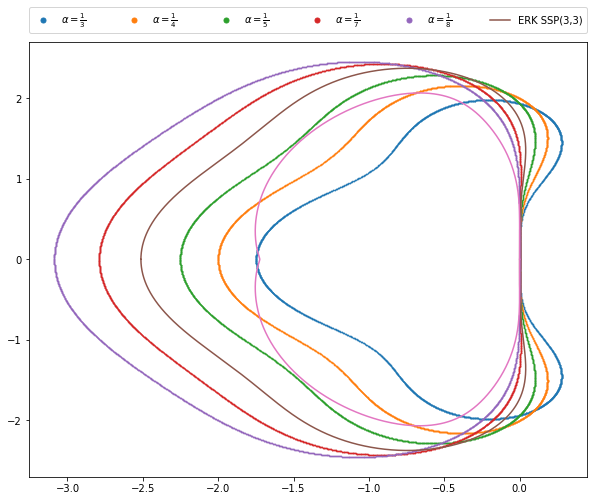

In [36]:
p = a*z**3 + poly_carac(2)

save_figsize = plt.rcParams['figure.figsize']
msize = 1
plt.rcParams['figure.figsize'] = [10, 8]
for n in (3,4,5,7,8):
  print(n,end="\r")
  bn = b_poly(p.subs(a,sp.Rational(1,n)))
  plt.plot(*reim(bn),'.',markersize=msize,label="$\\alpha = {}$".format(sp.latex(sp.Rational(1,n))))
print()
plt.plot(*reim(b3),label="ERK SSP(3,3)")
plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=8,ncol=6,mode="expand",borderaxespad=0.,markerscale=10)
#plt.xlim([-0.1,0.1])
plt.plot(*reim(-1.4*weno.data),label="WENO")
plt.show()
plt.rcParams['figure.figsize'] = save_figsize

La maximisation du domaine sur l'axe imaginaire permet de stabiliser avec la plus grande CFL possible un transport pur. Le coefficient $\alpha$ maximisant le domaine sur l'axe imaginaire avec un RK2 à 3 étages est $\alpha = \frac{1}{4}$.

> **Preuve :** considérons le polynôme caractéristique $R_{\alpha}$ d'un schéma RK2 à 3 étages avec un coefficient $\alpha$ :
> 
> $$
  R_{\alpha}(z) = 1 + z + \frac{z^2}{2} + \alpha z^3
$$
> 
> On cherche à évaluer le polynôme en $z=i\beta$, correspondant à l'intersection de l'ensemble $\{ z\ /\  |R_\alpha(z)|=1 \}$ avec l'axe imaginaire.
> 
> $$
  R_\alpha(i\beta) = 1 + i\beta - \frac{\beta^2}{2} - i\beta^3\alpha
$$
> 
> on souhaite un module égale à 1 :
> 
> $$
  1 = |R_\alpha(i\beta)|^2 = \left(1-\frac{\beta^2}{2}\right)^2 + \left(\beta - \beta^3\alpha \right)^2
$$
> 
> ce qui peut se simplifier par :
> 
> $$
  \alpha^2\beta^6 + (\frac{1}{4}-2\alpha)\beta^4 = 0
$$
>
>En supposant $\beta \neq 0$ :
>
>$$
  \alpha^2\beta^2 -2\alpha + \frac{1}{4} = 0
$$
>
>soit :
>
>$$
  \beta^2 = \frac{2\alpha - \frac{1}{4}}{\alpha^2}
$$
>
>on obtient ainsi une fonction $\beta^2:\alpha\mapsto \frac{2\alpha - \frac{1}{4}}{\alpha^2}$ dont on souhaite trouver le maximum (ou plus exactement le coefficient $\alpha$ où est atteint le maximum, ce qui explique que l'on ne s'intéresse qu'au coefficient $\beta^2$ et non explicitement $\beta$).
>
>$$
  \left(\beta^2\right)'(\alpha) = \frac{-2\alpha^2 + \frac{\alpha}{2}}{\alpha^4}
$$
>
>la dérivée s'annule en $\alpha = \frac{1}{4}$ □


La maximisation du domaine sur l'axe imaginaire ne permet pas rigoureusement de maximiser la CFL du couple de schéma RK$^\alpha N$-WENO mais permet de se donner une idée ; prenons par exemple le cas de RK2 à 3 étages, comme dit précédemment le coefficient $\alpha$ maximisant le domaine de stabilité sur l'axe imaginaire est $\alpha = \frac{1}{4}$, représenté par le courbe orange sur la figure, or il est possible d'obtenir une CFL plus importante avec le coefficient $\alpha=\frac{1}{5}$, pour lequel on représente le coefficient d'amplification en rose de WENO$\times$1.4 (sans aller chercher $\alpha=\frac{1}{6}$ qui correspond à RK3).

In [37]:
"""
  calcul systématique du meilleur coefficient alpha pour maximiser le domaine de stabilité sur l'axe imaginaire
"""

alpha = sp.symbols("\\alpha",real=True,positive=True)

def poly_RKsn(n):
  return alpha*z**(n+1) + poly_carac(n)

n=3 # avec n=2 on retrouve bien 1/4
beta = sp.symbols("\\beta",real=True,positive=True)
p = poly_RKsn(n)

alphas = []
# on cherche à résoudre $|p(ib)|^2 -1 = 0$, solutions auxquels on soustrait 0
# puis on dérive les solutions (qui dépendent de alpha) pour savoir où la dérivée s'annule et donc où beta
# est maximisé
for x in sp.solveset((sp.Abs(p.subs(z,beta*I))**2-1).collect(beta),beta**2)-sp.sets.FiniteSet(0):
  betaset = sp.solveset(x.diff(alpha),alpha,domain=sp.S.Reals)
  if betaset != sp.EmptySet() :
    alphas.extend(betaset)
(alphas[0],alphas[0].evalf())

⎛   2/3   3 ___                         ⎞
⎜  2      ╲╱ 2    1                     ⎟
⎜- ──── + ───── + ──, 0.0464588888312965⎟
⎝   36      36    18                    ⎠

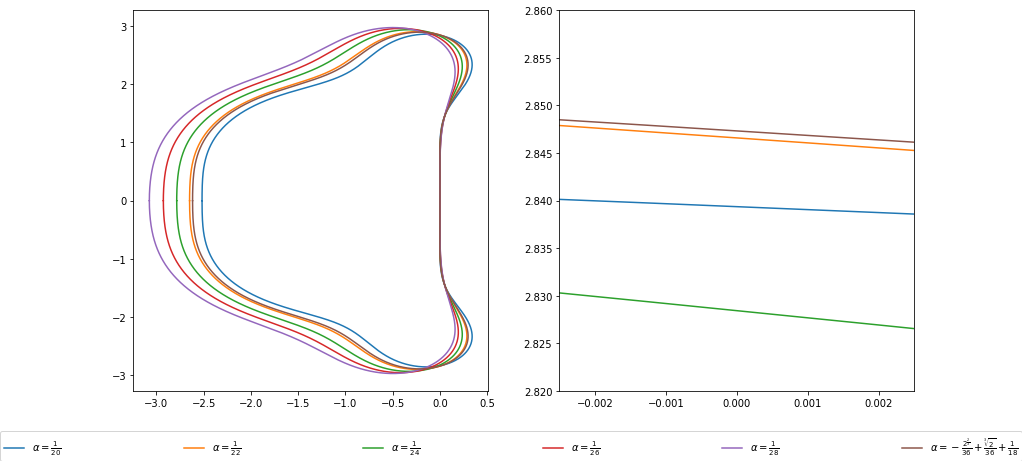

In [38]:
"""
  vérification graphique de la solution trouvée
"""
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,7))

p = poly_RKsn(3)

for n in (20,22,24,26,28):
  print(n,end="\r")
  bn = b_poly(p.subs(alpha,sp.Rational(1,n)))
  ax1.plot(*reim(bn),markersize=msize,label="$\\alpha = {}$".format(sp.latex(sp.Rational(1,n))))
  ax2.plot(*reim(bn),markersize=msize)
print(alphas[0],end="\r")
bn = b_poly(p.subs(alpha,alphas[0]))
ax1.plot(*reim(bn),markersize=msize,label="$\\alpha = {}$".format(sp.latex(alphas[0])))
ax2.plot(*reim(bn),markersize=msize)
print(" "*len(str(alphas[0])))

fig.legend(loc=4,ncol=6,mode="expand",borderaxespad=0.,markerscale=10)

ax2.set_xlim([-0.0025,0.0025]) ; ax2.set_ylim([2.82,2.86])

plt.show()

## 3.5 Domaine de stabilité intermédiaire

Juste pour tester, on peut essayer de tracer le domaine de stabilité de chaque étage. Je ne sais pas si cela a réellement un sens. La majorité des schémas RK que j'ai pu voir commence par une étape d'Euler explicite, or celle-ci est instable avec le schéma WENO, donc la stabilité est apporté par les étages supplémentaires.

L'idée de tracer ces domaines provient du survol que j'ai pu effectué des travaux de Ketcheson (ce qu'il appelle *internal stability*).

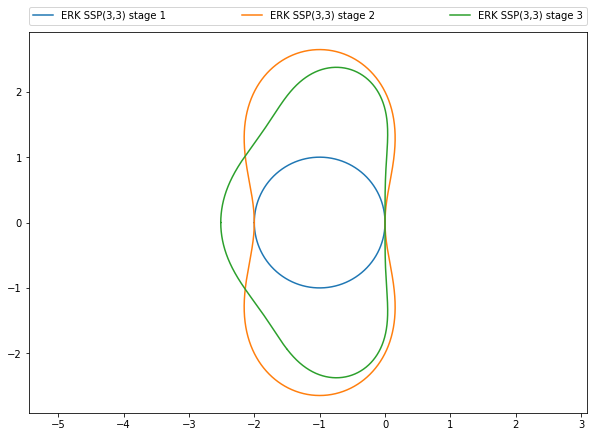

⎛        2           3    2        ⎞
⎜       z    z      z    z         ⎟
⎜z + 1, ── + ─ + 1, ── + ── + z + 1⎟
⎝       4    2      6    2         ⎠

In [39]:
"""
RK3 Shu-Osher stages stability
"""
u1 = un + dt*L(un)
u2 = sp.Rational(3,4)*un + sp.Rational(1,4)*u1 + sp.Rational(1,4)*dt*L(u1)
un1 = sp.Rational(1,3)*un + sp.Rational(2,3)*u2 + sp.Rational(2,3)*dt*L(u2)

RKpstages = (u1.subs(lamb*dt,z).expand().collect(un).collect(z)/un,
u2.subs(lamb*dt,z).expand().collect(un).collect(z)/un,
un1.subs(lamb*dt,z).expand().collect(un).collect(z)/un)

b3s1 = b_poly(RKpstages[0])
b3s2 = b_poly(RKpstages[1])
b3s3 = b_poly(RKpstages[2])


save_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [10,7]

plt.plot(*reim(b3s1),label="ERK SSP(3,3) stage 1")
plt.plot(*reim(b3s2),label="ERK SSP(3,3) stage 2")
plt.plot(*reim(b3s3),label="ERK SSP(3,3) stage 3")

plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=8,ncol=6,mode="expand",borderaxespad=0.,markerscale=10)
plt.axis('equal')
plt.show()

plt.rcParams['figure.figsize'] = save_figsize
RKpstages

# 4. Étude de couples RK$N$-WENO5

On regarde maintenant la stabilité de WENO avec les différents schémas RK$N$. Pour cela on trace le domaine de stabilité du schéma RK choisi, et on compare ce domaine avec celui du coefficient d'amplification du schéma WENO5. Le schéma est linéairement stable s'il existe un coefficient $\sigma$, appelé CFL, permettant de faire *rentrer* la courbe du schéma WENO dans le domaine de stabilité de RK$N$.

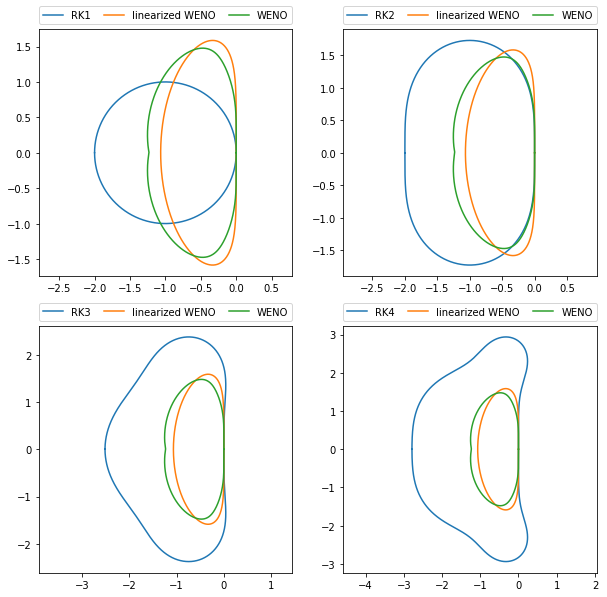

In [40]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
coords = [(x,y) for x in range(2) for y in range(2)]

for (n,b) in enumerate((b1,b2,b3,b4),start=1):
  ax[coords[n-1]].plot(*reim(b),label="RK%i"%n)
  ax[coords[n-1]].plot(*reim(-wenol.data_z),label="linearized WENO")
  ax[coords[n-1]].plot(*reim(-weno.data),label="WENO")
  ax[coords[n-1]].axis('equal')
  ax[coords[n-1]].legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=3,ncol=3,mode="expand",borderaxespad=0.)

plt.show()

## 4.1 Automatisation du calcul de CFL

Il est maintenant intéressant d'étudier quel est le rapport d'homothétie liant le mieux RK$N$ à WENO, ce rapport d'homothétie est $\sigma$ le nombre de CFL. Dans l'article [Wang R. and Spiteri R. J. (2007)](https://doi.org/10.1137/050637868) une approximation grossière est faite en supposant que RK$N$, pour $N\geq 3$ contient un rectangle contenant la courbe de WENO linéarisé. Une estimation est ainsi faite d'un $\sigma_0 \leq \sigma$. Il est possible dans un premier temps d'estimer numériquement un coefficient $\sigma_{\texttt{num}}$ tel que :

$$
  \sigma_0 \leq \sigma_{\texttt{num}} \leq \sigma
$$

travail effectué dans [Motamed M. and Macdonald C. B. (2010)](https://doi.org/10.1007/s10915-010-9423-9). Il est aussi possible de travailler sur la version complète du schéma WENO, en prenant en compte dans l'analyse de von Neumann de la partie non linéaire.

### 4.1.1 Estimation sur WENO linéarisé

Il est plus facile de travailler sur des tableaux des données du WENO et de RK$N$ de même dimension, et avec des données triées par argument (pour estimer le rapport de l'homothétie).

In [41]:
def cfl( z_weno , b_rk , display=True ):
  zb = [ min(z_weno,key=lambda z:np.abs(np.angle(z)-np.angle(b_))) for b_ in b_rk ]
  sigs = np.array([ np.array([np.angle(z),np.abs((b_)/(z)) if np.abs(z)>1E-2 else float("nan")]) for (z,b_) in zip(zb,b_rk) ])
  if display :
    plt.plot(sigs[:,0],sigs[:,1])
    plt.xlabel("φ");plt.ylabel("σ")
    plt.show()
  return min(sigs[:,1])

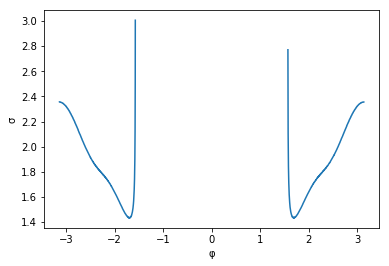

1.433683174288281

In [42]:
sigma_l = cfl(-wenol.data_z,b3[::3])
sigma_l

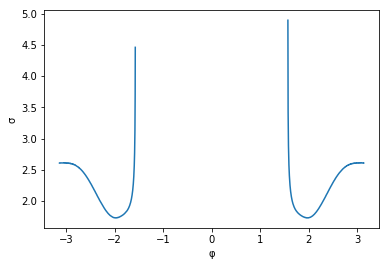

1.7311984792232984

In [43]:
cfl(-wenol.data_z,b4[::4])

### 4.1.2 Estimation sur WENO

On utilise maintenant la même fonction pour effectuer le même travail sur WENO complet.

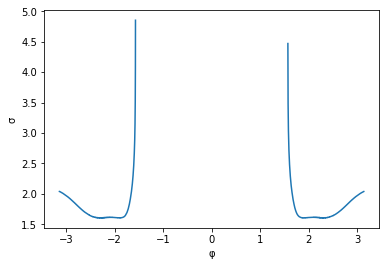

1.6064312370501719

In [44]:
sigma_w = cfl(-weno.data,b3[::3])
sigma_w

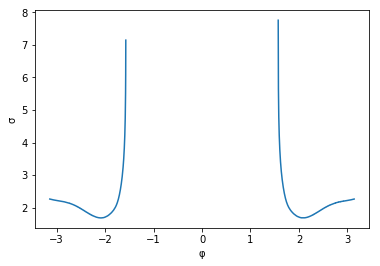

1.6805707317544747

In [45]:
cfl(-weno.data,b4[::4])

On observe (ce qui est relativement étrange) une CFL plus faible dans le cas complet que linéarisé pour le couple RK4-WENO5. Ceci s'explique par la forme du domaine, on peut voir le cas extrême avec le RK d'ordre 3 à 4 étages maximisant le domaine de stabilité sur l'axe imaginaire mais ayant une CFL peut avantageuse face à d'autres méthodes.

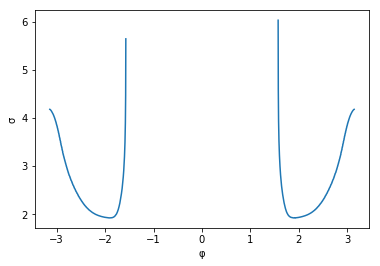

1.9235340506290004

In [46]:
sigma_w34 = cfl(-weno.data,b34[::4])
sigma_w34

### 4.1.3 Validation des CFL

On s'intéresse ici à regarder où s'effectue la contrainte de la CFL. Il peut être intéressant numériquement d'exciter le mode particulier avec le bon $\Delta x$ qui stabilise ou non le schéma.

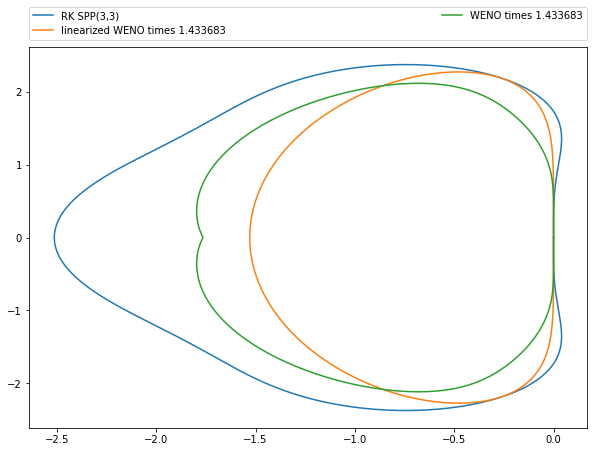

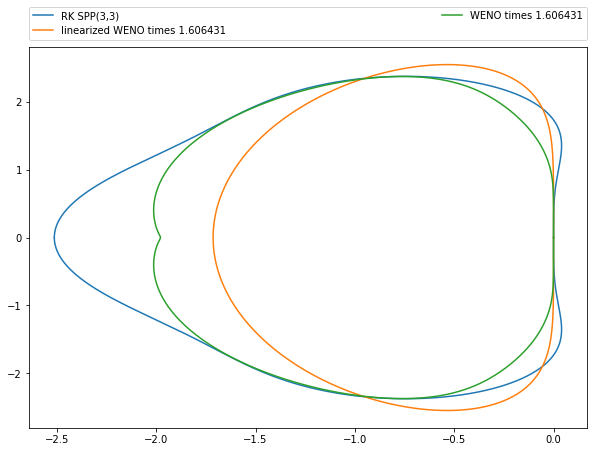

In [47]:
save_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [10, 7]

b_rk = b3[::3]; n=3
plt.plot(*reim(b_rk[:]),label="RK SPP(3,3)")
plt.plot(*reim(-sigma_l*wenol.data_z[:]),label="linearized WENO times %f"%sigma_l)
plt.plot(*reim(-sigma_l*weno.data[:]),label="WENO times %f"%sigma_l)
#plt.axis('equal')
plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=3,ncol=2,mode="expand",borderaxespad=0.)
plt.show()

plt.plot(*reim(b_rk[:]),label="RK SPP(3,3)")
plt.plot(*reim(-sigma_w*wenol.data_z[:]),label="linearized WENO times %f"%sigma_w)
plt.plot(*reim(-sigma_w*weno.data[:]),label="WENO times %f"%sigma_w)
#plt.axis('equal')
plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=3,ncol=2,mode="expand",borderaxespad=0.)
plt.show()

(data.phi[300],np.angle(wenol.data_z[300]),wenol.data_z)

plt.rcParams['figure.figsize'] = save_figsize

On effectue maintenant un zoom dans le cas de la CFL `sigma_w`.

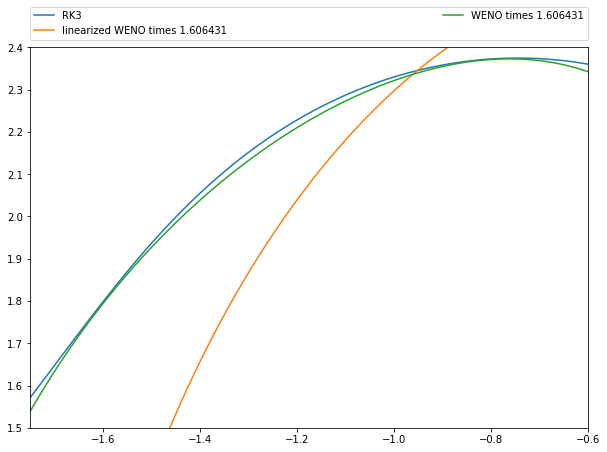

In [48]:
save_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [10, 7] # default:[6,4]

plt.plot(*reim(b3),label="RK%i"%n)
plt.plot(*reim(-sigma_w*wenol.data_z),label="linearized WENO times %f"%sigma_w)
plt.plot(*reim(-sigma_w*weno.data),label="WENO times %f"%sigma_w)
plt.xlim([-1.75,-0.6])
plt.ylim([1.5,2.4])
plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=3,ncol=2,mode="expand",borderaxespad=0.)
plt.show()

plt.rcParams['figure.figsize'] = save_figsize

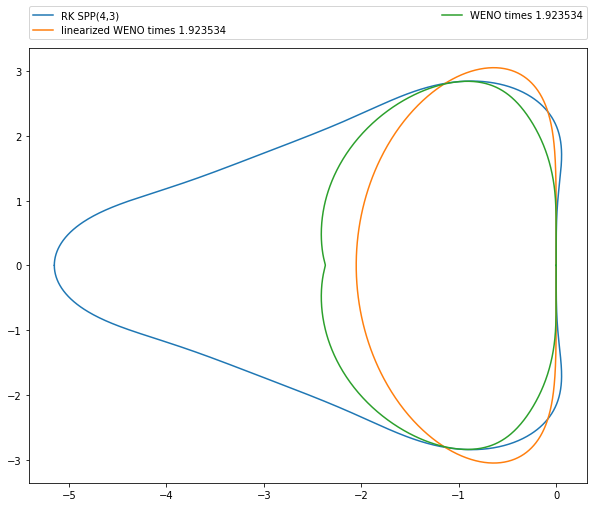

In [49]:
"""
  Stability of ERK SSP(4,3)-WENO5 with a CFL of 1.923 with the computation time than RK4 (and a "bad" CFL)
"""

save_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [10, 8]

b_rk = b34[::4]
plt.plot(*reim(b_rk[:]),label="RK SPP(4,3)")
plt.plot(*reim(-sigma_w34*wenol.data_z[:]),label="linearized WENO times %f"%sigma_w34)
plt.plot(*reim(-sigma_w34*weno.data[:]),label="WENO times %f"%sigma_w34)
#plt.axis('equal')
plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=3,ncol=2,mode="expand",borderaxespad=0.)
plt.show()

plt.rcParams['figure.figsize'] = save_figsize

On s'intéresse maintenant aux méthodes de type Runge-Kutta d'ordre 3 à 4 étages avec la recherche du meilleur coefficient $\alpha$. On trace donc différents couples de schémas en représentant le domaine de stabilité du schéma en temps, et le coefficient d'amplification du schéma WENO multiplié par sa CFL.

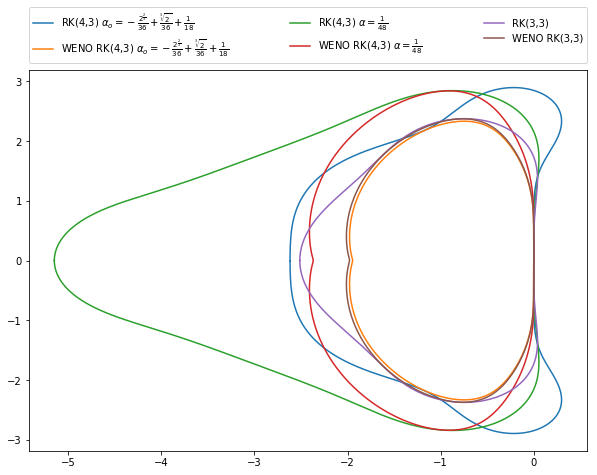

In [50]:
save_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [10, 7]

plt.plot(*reim(b_poly(p.subs(alpha,alphas[0]))),label="RK(4,3) $\\alpha_o = {}$".format(sp.latex(alphas[0])))
plt.plot(*reim(-1.579*weno.data),label="WENO RK(4,3) $\\alpha_o = {}$".format(sp.latex(alphas[0])))
plt.plot(*reim(b34),label="RK(4,3) $\\alpha = {}$".format(sp.latex(sp.Rational(1,48))))
plt.plot(*reim(-1.923*weno.data),label="WENO RK(4,3) $\\alpha = {}$".format(sp.latex(sp.Rational(1,48))))
plt.plot(*reim(b3),label="RK(3,3)")
plt.plot(*reim(-1.606*weno.data),label="WENO RK(3,3)")
plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=3,ncol=3,mode="expand",borderaxespad=0.)
plt.show()

plt.rcParams['figure.figsize'] = save_figsize

Les couples de schémas représentés (en *CFLisant* WENO) :

* RK(4,3) $\alpha_{\text{opt}} = - \frac{\left(-2 + \sqrt[3]{2}\right) \left(1 + \sqrt[3]{2}\right)}{36}$ (bleu) WENO (orange) : schéma temporel de type Runge-Kutta d'ordre 3 à 4 étages qui maximise le domaine de stabilité sur l'axe imaginaire.
* RK(4,3) $\alpha = \frac{1}{48}$ (vert) WENO (rouge) : schéma temporel aussi appelé RK SSP(4,3).
* RK(3,3) (violet) WENO (marron) : schéma temporel RK3 classique.

Le schéma temporel RK(4,3) $\alpha_{\text{opt}}$ (en bleu sur la figure) est celui qui maximise le domaine de stabilité sur l'axe imaginaire, malgré cela la condition CFL de ce schéma (1.579) lié à WENO est similaire à celle du couple RK SSP(3,3)-WENO (1.579 contre 1.606 pour le RK SSP(3,3)).

Récapitulatif des conditions CFL entre différents schémas temporels et WENO5 :

| RK(4,3) $\alpha_{\text{opt}}$ | RK SSP(4,3) | RK SSP(3,3) |
|-------------------------------|-------------|-------------|
| 1.579                         | 1.923       | 1.606       |

On remarque qu'il n'est pas nécessaire dans le cadre de WENO de maximiser le domaine sur l'axe imaginaire (le schéma étant diffusif). Étudions maintenant l'évolution de la CFL en fonction de $\alpha$.


49


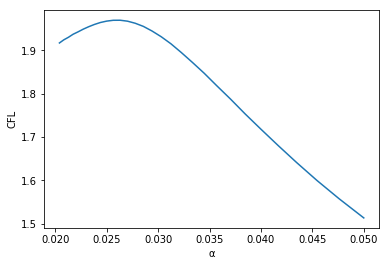

(1/38, 1.9691209541406522)

In [51]:
def cfl( z_weno , b_rk ):
  zb = [ min(z_weno,key=lambda z:np.abs(np.angle(z)-np.angle(b_))) for b_ in b_rk[:300] ]
  sigs = [ np.abs((b_)/(z)) if np.abs(z)>1E-2 else float('nan') for (z,b_) in zip(zb,b_rk[:300]) ]
  return min(sigs)

cfls = []
ns = range(20,50,1)

for n in ns:
  print(n,end="\r")
  bn = b_poly(p.subs(a,sp.Rational(1,n)))
  cfls.append(cfl(-weno.data,bn[::4]))
print()

plt.plot([1./n for n in ns],cfls)
plt.xlabel("α");plt.ylabel("CFL")
plt.show()

(sp.Rational(1,ns[cfls.index(max(cfls))]),max(cfls)) # value where the is the maximum CFL and the CFL


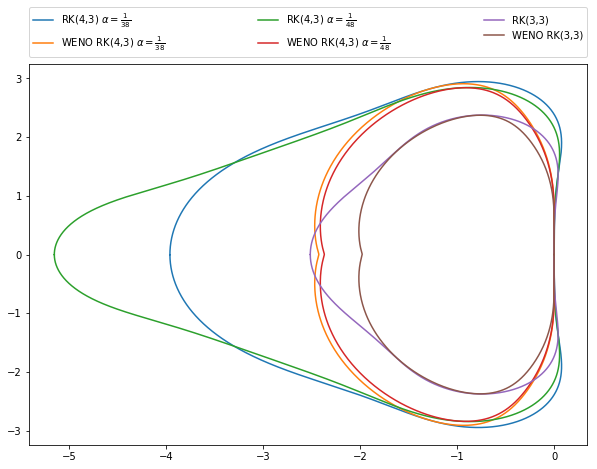

In [52]:
## %config InlineBackend.figure_format = 'retina'
save_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [10, 7]

p = poly_RKsn(3)
plt.plot(*reim(b_poly(p.subs(a,sp.Rational(1,38)))),label="RK(4,3) $\\alpha = {}$".format(sp.latex(sp.Rational(1,38))))
plt.plot(*reim(-1.969*weno.data),label="WENO RK(4,3) $\\alpha = {}$".format(sp.latex(sp.Rational(1,38))))
plt.plot(*reim(b34),label="RK(4,3) $\\alpha = {}$".format(sp.latex(sp.Rational(1,48))))
plt.plot(*reim(-1.923*weno.data),label="WENO RK(4,3) $\\alpha = {}$".format(sp.latex(sp.Rational(1,48))))
plt.plot(*reim(b3),label="RK(3,3)")
plt.plot(*reim(-1.606*weno.data),label="WENO RK(3,3)")
plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=3,ncol=3,mode="expand",borderaxespad=0.)
plt.show()

plt.rcParams['figure.figsize'] = save_figsize

Le récapitulatif des conditions CFL devient :


| RK(4,3) $\alpha_{\text{opt}}$ | RK SSP(4,3) | RK(4,3) $\alpha_{\text{max}}$ | RK SSP(3,3) |
|-------------------------------|-------------|-------------------------------|-------------|
| 1.579                         | 1.923       | 1.969                         | 1.606       |

Il est sans doute possible de trouver une CFL légèrement supérieur au cas $\alpha_{\text{max}}=\frac{1}{38}$ mais cela donne un ordre d'idée assez précis de la CFL qu'il est possible d'atteindre au maximum. Le schéma étant déjà écrit pour le cas RK SSP(4,3), correspondant au cas $\alpha_{\text{RK SSP(4,3)}} = \frac{1}{48}$ avec une CFL relativement proche, il ne semble pas nécessaire de s'impliquer dans la recherche du schéma optimal en résolvant les relations d'ordres.

### 4.1.4 Calcul de CFL pour des schémas RK d'ordre élevé

On peut aussi s'intéresser aux ordres plus élevé. Il s'agit là plus d'une démonstration technique qu'une étude guidée par un intérêt scientifique.

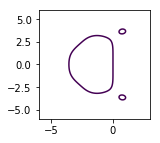

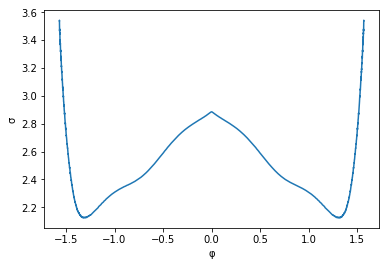

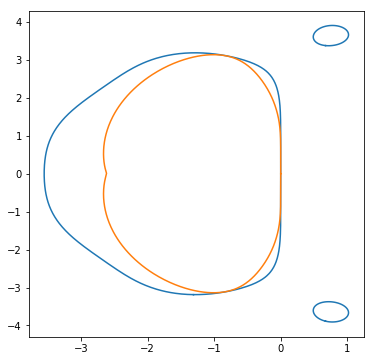

2.1244173399982054


In [53]:
def cfl( z_weno , b_rk , display=True ):
  sigs = np.array([ np.array([np.angle(z),np.abs((b_)/(z))]) for (z,b_) in zip(z_weno,b_rk) if np.abs(z)>1e-1 and np.abs((b_)/(z)) > 1. ])
  if display :
    plt.plot(sigs[50:-50,0],sigs[50:-50,1])
    plt.xlabel("φ");plt.ylabel("σ")
    plt.show()
  return min(sigs[50:-50,1])

R_rk6   = sp.Abs(poly_carac(6))

save_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [2, 2]
# Pour le moment l'obtention des segments demande aussi le tracé de la courbe
# j'ai commencé à regarder comment faire pour avoir un `plt.hidden` ou similaire
dat0 = contour(R_rk6,z,(-6.,3.,500),(-6.,6.,500), levels=[1.]).allsegs
plt.show()
plt.rcParams['figure.figsize'] = save_figsize

# on regarde, pour l'étude de la stabilité, que le domaine central
dat1 = max(dat0[0][:],key=lambda l:len(l))
dat1_c = [ re+im*1j for (re,im) in zip(dat1[:,0],dat1[:,1]) ] # on convertit les données en complexes
# on trie les données selon l'argument
b6 = np.array([ min(dat1_c,key=lambda b:np.abs(np.angle(b)-np.angle(-z_)) ) for z_ in weno.data ])

# calcul de la CFL
sig_rk6 = cfl(weno.data[:],b6[:])

save_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [6, 6]
[ plt.plot(c[:,0],c[:,1],color=palette[0]) for c in dat0[0] ]
plt.plot(*reim(-sig_rk6*weno.data),color=palette[1])
plt.show()

plt.rcParams['figure.figsize'] = save_figsize

print(sig_rk6)

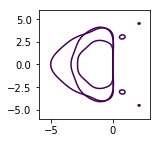

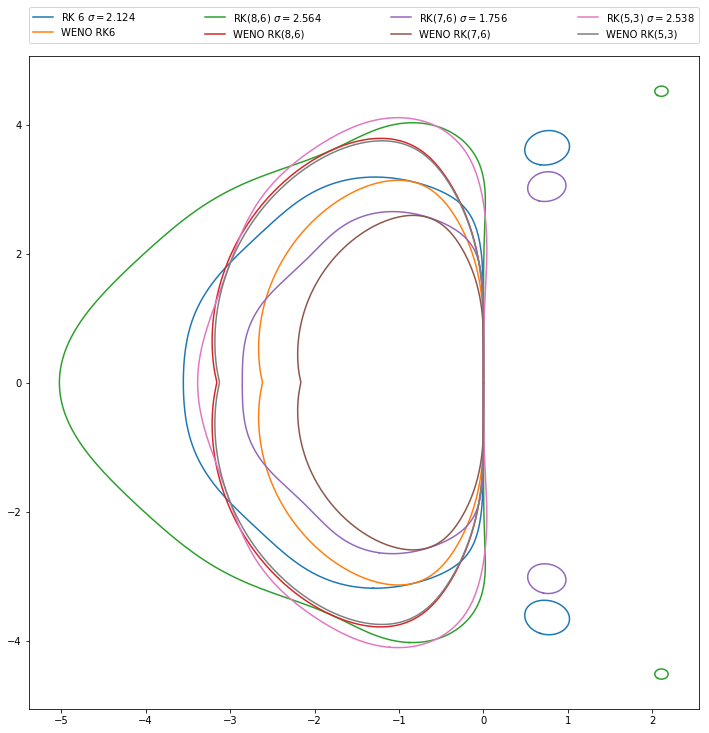

In [54]:
R_rk6_8 = sp.Abs(prk6_8)
R_rk6_7 = sp.Abs(prk6_7)
R_rk3_5 = sp.Abs(prk3_5)

save_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [2,2]
dat0_rk6_8 = contour(R_rk6_8,z,(-6.,3.,500),(-6.,6.,500), levels=[1.]).allsegs
dat0_rk6_7 = contour(R_rk6_7,z,(-6.,3.,500),(-6.,6.,500), levels=[1.]).allsegs
dat0_rk3_5 = contour(R_rk3_5,z,(-6.,3.,500),(-6.,6.,500), levels=[1.]).allsegs
plt.show()
plt.rcParams['figure.figsize'] = save_figsize

def cfl_multicontour ( dat ) :
  tmp = max(dat[:],key=lambda l:len(l))
  tmp_c = [ re+im*1j for (re,im) in zip(tmp[:,0],tmp[:,1]) ]
  b = np.array([ min(tmp_c,key=lambda b:np.abs(np.angle(b)-np.angle(-z_)) ) for z_ in weno.data ])
  return cfl(weno.data,b,display=False)

sig_rk6_8 = cfl_multicontour( dat0_rk6_8[0] )
sig_rk6_7 = cfl_multicontour( dat0_rk6_7[0] )
sig_rk3_5 = cfl_multicontour( dat0_rk3_5[0] )

save_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [12, 12]

# RK6
[ plt.plot(c[:,0],c[:,1],color=palette[0]) for c in dat0[0] ]
plt.plot([0],[0],color=palette[0],label="RK 6 $\\sigma = {0:.3f}$".format(sig_rk6))
plt.plot(*reim(-sig_rk6*weno.data),color=palette[1],label="WENO RK6")

# RK(8,6)
[ plt.plot(c[:,0],c[:,1],color=palette[2]) for c in dat0_rk6_8[0] ]
plt.plot([0],[0],color=palette[2],label="RK(8,6) $\\sigma = {0:.3f}$".format(sig_rk6_8))
plt.plot(*reim(-sig_rk6_8*weno.data),color=palette[3],label="WENO RK(8,6)")

# RK(7,6)
[ plt.plot(c[:,0],c[:,1],color=palette[4]) for c in dat0_rk6_7[0] ]
plt.plot([0],[0],color=palette[4],label="RK(7,6) $\\sigma = {0:.3f}$".format(sig_rk6_7))
plt.plot(*reim(-sig_rk6_7*weno.data),color=palette[5],label="WENO RK(7,6)")

# RK(5,3)
[ plt.plot(c[:,0],c[:,1],color=palette[6]) for c in dat0_rk3_5[0] ]
plt.plot([0],[0],color=palette[6],label="RK(5,3) $\\sigma = {0:.3f}$".format(sig_rk3_5))
plt.plot(*reim(-sig_rk3_5*weno.data),color=palette[7],label="WENO RK(5,3)")

plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=3,ncol=4,mode="expand",borderaxespad=0.)
plt.show()

plt.rcParams['figure.figsize'] = save_figsize

Récapitulatif des CFL d'ordre supérieur :

| RK (6,6) | RK (8,6) | RK (7,6) | RK (5,3) |
|----------|----------|----------|----------|
| 2.124    | 2.564    | 1.756    | 2.538    |

Le RK(6,6) est purement hypothétique puisqu'actuellement aucun schéma de type Runge-Kutta d'ordre 6 à 6 étages n'a été trouvé.

## 4.2 Validation par simulation numérique

Nous nous intéressons ici qu'à la vérification du travail sur le schéma WENO non linéarisé, en comparant ceci au cas linéarisé.

Il est maintenant nécessaire de tester en différents points du domaine et de tester la validité des dires sur la CFL. Pour s'assurer que l'on excite qu'un seul mode il est nécessaire d'effectuer le transport d'un cosinus avec un mode $\xi$ et un $\Delta x$ vérifiant :

$$
  \phi = 2\pi\xi\Delta x
$$

> **Petite note pour Paul:** puisque je fais du numérique je prends $\xi=2$ c'est très bien, et je ne travaille pas sur des schémas capables de gérer des modes élevé comme Joackim avec son mode 41 ^^

On prendra le mode d'excitation $\xi=2$ par conséquent pour un $\phi$ donné on calcul un $\Delta x$ :

$$
  \Delta x = \frac{\phi}{4\pi}
$$

Nous fixons la CFL $\sigma^{W_{NL}} \approx 1.606$ tel que donné par l'étude de CFL du couple WENO non linéarisé avec RK3. L'angle $\phi$ est choisi en prenant l'argument d'un point sur la courbe $\tilde{z}$ (donc un coefficient d'amplification du WENO linéarisé) tel qu'il soit en dehors du domaine de stabilité de RK3. Numériquement nous prendrons : $\phi = 1.38337934$.

Nous effectuons une simulation de :

$$
  \begin{cases}
    \partial_t u + \partial_x u = 0 \\
    u^0 = \cos(2 x)
  \end{cases}
$$

sur le domaine spatiale $[0,2\pi]$, jusqu'au temps final $T_f = 15$. Nous prendrons comme nombre de CFL $\sigma^{W_{NL}} \approx 1.606$.

|         step          |         value         |
|-----------------------|-----------------------|
| $\Delta x$            | `0.11008583006610187` |
| $\Delta t$            | `0.15742273699452566` |

La simulation s'effectue avec $N=57$ points.

![Simulation du schéma WENO avec une CFL à 1.606](img/translate/translate_Wnlsnl.png)

Nous constatons une stabilité du schéma WENO5-RK3, malgré quelques oscillations, celles-ci ne divergent pas même en temps longs, le schéma est malheureusement très diffusif sous ces conditions. Ces oscillations s'estompent dès que le contraint moins la CFL, en prenant par exemple pour CFL $\sigma^{W_L} \approx 1.433$ on obtient :

![Simulation du schéma WENO avec une CFL à 1.433](img/translate/translate_Wnlsl.png)

ce qui laisse sous entendre que le coefficient d'amplification du schéma WENO est bien donné par la courbe verte. De plus en prenant une CFL légèrement supérieur ($\approx 1.7$) le schéma est instable (la solution diverge).

Un test avec un schéma WENO linéarisé, c'est-à-dire avec des poids $w_i = \gamma_i$ est aussi effectué. On remarque qu'il est alors nécessaire de conserver la CFL à $\sigma^{W_L} \approx 1.433$ pour stabiliser le schéma.

![Simulation du schéma WENO linéarisé avec une CFL à 1.606](img/translate/translate_Wlsnl.png)
![Simulation du schéma WENO linéarisé avec une CFL à 1.433](img/translate/translate_Wlsl.png)

Cela semble confirmer le calcul de CFL pour le WENO complet.

> Le domaine de stabilité de RK6 n'étant pas connexe, il est possible d'illustrer qu'en excitant un mode $\xi$ particulier, on peut stabiliser le schéma en prenant une CFL $\frac{\Delta t}{\Delta x}$ plus grande, et le rentre instable avec une CFL plus petite.

## 4.3 Estimation du coût numérique

Le principal coût numérique en temps de calcul est l'évaluation du schéma WENO à chaque étage d'un schéma Runge-Kutta. On peut estimer le coût de chaque étage nécessitant l'approximation d'une dérivée par la méthode WENO à 1, on se retrouve alors avec le tableaux de coûts suivant :


| couple           | $\sigma_i$ | nombre d'itérations         | coût par itération | coût par unité de temps       |
|------------------|------------|-----------------------------|--------------------|-------------------------------|
| RK SSP(3,3)-WENO | $1,606$    | $n \propto 0,62 \times T_f$ | 3                  | $\frac{3}{1,606}\approx 1,86$ |
| RK SSP(4,3)-WENO | $1,923$    | $n \propto 0,52 \times T_f$ | 4                  | $\frac{4}{1,923}\approx 2,08$ |
| RK SSP(4,4)-WENO | $1,680$    | $n \propto 0,59 \times T_f$ | 4                  | $\frac{4}{1,680}\approx 2,38$ |

La comparaison s'effectue avec des paramètres de simulations ($\Delta x$, $T_f$, ...) fixés, par conséquent le pas en espace peut être pris égal à 1 sans perdre en généralité ; nous prenons en revanche le plus grand pas de temps $\Delta t = \sigma\Delta x$ permis par la CFL $\sigma$. Le nombre d'itérations est obtenu par $n=\frac{T_f}{\Delta t}$ et est proportionnel à $n \propto \frac{1}{\sigma}T_f$ pour un $\Delta x$ fixé. Le coût par itération correspond au nombre d'évaluation de la méthode WENO par itération, et correspond donc au nombre d'étages de la méthode d'intégration en temps. Le coût par unité de temps est obtenu en calculant le coût de la simulation jusqu'au temps final 1.

Le coût par unité de temps du couple RK SSP(4,3)-WENO reste supérieur à RK SSP(3,3)-WENO malgré la CFL plus grande. La plus grande CFL de la méthode RK(4,3) $\alpha_{\text{max}}$ ne permet pas de réduire drastiquement le coût par unité de temps ($\approx 2,03$), il serait nécessaire d'avoir une CFL $\sigma \geq 2,14$ avec un RK à 4 étages pour avoir un coût par unité de temps inférieur au couple RK SSP(3,3)-WENO. Il semblerait, en extrapolant les résultats de [Wang R. and Spiteri R. J. (2007)](https://doi.org/10.1137/050637868) à propos de la stabilité du couple RK2 (optimal) à $s$ étages - WENO 5 (corollaire 3.10), qu'il ne soit pas possible de stabiliser WENO 5 avec un RK2 à 4 étages, il semble donc difficile de trouver une CFL permettant de diminuer le coût par unité de temps.

On peut de la même manière estimer la CFL minimale d'une méthode de type Runge-Kutta à 5 étages pour diminuer le coût par unité de temps ($\sigma \geq 2,67$).

> Ce coût numérique n'est qu'un estimateur du temps de calcul, fonctionnant aussi pour l'utilisation de la mémoire (sauf cas particulier d'un schéma explicite Runge-Kutta dont la table de Butcher est sous diagonale, qui permet des optimisations importantes en mémoire). On ne prend pas en compte le gain sur l'erreur numérique par exemple.

La diminution de l'erreur peut s'obtenir aussi en prenant un pas de temps plus petit, ainsi il est intéressant d'étudier le coût par unité de temps de RK SSP(3,3)-WENO avec une CFL $\alpha\sigma$. Tant que $\alpha \geq 0.785$ il est plus intéressant de réduire le pas de temps pour diminuer l'erreur, en deçà le coût numérique devient moindre avec une méthode d'ordre plus élevé (RK SSP(4,4) pour l'exemple).

En estimant toujours le coût au nombre d'étages de la méthode, on peut s'intéresser aux couples d'ordre suppérieurs :


| couple        | $\sigma_i$ | nombre d'itérations          | coût par itération | coût par unité de temps        |
|---------------|------------|------------------------------|--------------------|--------------------------------|
| RK (8,6)-WENO | $2.564$    | $n \propto 0.390 \times T_f$ | 8                  | $\frac{8}{2.564}\approx 3.120$ |
| RK (7,6)-WENO | $1.756$    | $n \propto 0.569 \times T_f$ | 7                  | $\frac{7}{1.756}\approx 3.986$ |
| RK (5,3)-WENO | $2.538$    | $n \propto 0.394 \times T_f$ | 5                  | $\frac{5}{2.538}\approx 1.970$ |

On remarque que la méthode RK (5,3) a un coût numérique similaire à cela de RK SSP(3,3) bien qu'ayant 5 étages. L'ordre de la méthode étant le même, je ne suis pas convaincu par l'intérêt de la méthode.

# 5. Schémas Lawson et exponentiels

Les schémas de type Runge-Kutta permettent la résolution d'une EDP du type :

$$
  \dot{u} = \lambda u
$$

avec $\lambda\in\mathbb{C}$. Le problème qui nous intéresse ici est du type :

$$
  \dot{u} = \lambda u + \mu u
$$

avec $\lambda,\mu\in\mathbb{C}$. Les coefficients $\lambda$ et $\mu$ représentent différents opérateurs. Dans le contexte de la résolution de l'équation de Vlasov, $\lambda$ peut représenter la discrétisation en espace (via une transformée de Fourier), et $\mu$ celle en temps (via la méthode WENO). Pour ces raisons on peut vouloir *faire rentrer* une opération sous la dérivée en temps via une exponentielle :

$$
  \partial_t \left(e^{-\lambda t}u\right) = e^{-\lambda t}\mu u
$$

Pour construire un schéma en temps, il faut intégrer sur $[t^n,t^{n+1})$ :

$$
  \int_{t^n}^{t^{n+1}} \partial_t \left(e^{-\lambda t}u\right)\,\mathrm{d}t = \int_{t^n}^{t^{n+1}}e^{-\lambda t}\mu u\,\mathrm{d}t
$$

On évalue de manière exacte le terme de gauche :

$$
  e^{-\lambda t^n}\left(e^{-\lambda\Delta t}u(t^{n+1}) - u(t^n)\right) = \int_{t^n}^{t^{n+1}}e^{-\lambda t}\mu u\,\mathrm{d}t
$$

soit :

$$
  e^{-\lambda\Delta t}u(t^{n+1}) - u(t^n) = \int_{t^n}^{t^{n+1}}e^{-\lambda (t-t^n)}\mu u\,\mathrm{d}t
$$

En effectuant le changement de variable $\tau = t-t^n$ on trouve une intégrale seulement sur le pas de temps $\Delta t$, ce qui est rassurant quant à la stabilité numérique en temps long.

## 5.1 Schémas exponentielles

Deux options existent pour traiter le terme de droite, la première consiste à effectuer une quadrature de l'intégrale, ce qui revient à reconstruire une méthode de type Runge-Kutta, le schéma ainsi obtenue s'appelle un schéma IFRK (pour *integrating factor Runge-Kutta*) ou Lawson ; la seconde consiste à résoudre de manière exacte l'exponentielle, en approximant $u(t) \approx u(t^n)$. On obtient alors :

$$
  e^{-\lambda\Delta t}u^{n+1} - u^n = \frac{\mu}{\lambda} u^n (1-e^{-\lambda\Delta t})
$$

soit :

$$
  u^{n+1} = e^{\lambda\Delta t}u^n + \frac{\mu}{\lambda} u^n (e^{\lambda\Delta t}-1)
$$

Pour étudier la stabilité du schéma on se propose de poser :

* $z_1 = \lambda\Delta t$
* $z_2 = \mu\Delta t$

On obtient alors l'expression suivante :

$$
  u^{n+1} = \left(e^{z_1} + \frac{z_2}{z_1}(e^{z_1}-1)\right)u^n
$$

On se propose maintenant d'étudier le module du coefficient d'amplification. En supposant que l'opérateur représenté par $z_1$ est peu visqueux, c'est-à-dire que $\Re(z_1) \approx 0$, on écrit alors $z_1 = ib_1$.

$$
  R(z_1,z_2) = \left| e^{ib_1} - i\frac{z_2}{b_1}(e^{ib_1}-1) \right|
$$

En factorisant par $e^{ib_1}$, qui est de module 1, on obtient :

$$
  R(z_1,z_2) = \left| 1 + i\frac{z_2}{b_1}(e^{-ib_1} - 1) \right|
$$

On écrit maintenant $z_2 = a_2 + ib_2$ avec $a_2,b_2\in\mathbb{R}$, le module peut alors s'exprimer explicitement :

$$
  R(z_1,z_2)^2 = \left| 1 + i\frac{a_2+ib_2}{b_1}(\cos(b_1) - i\sin(b_1) - 1) \right|^2
$$

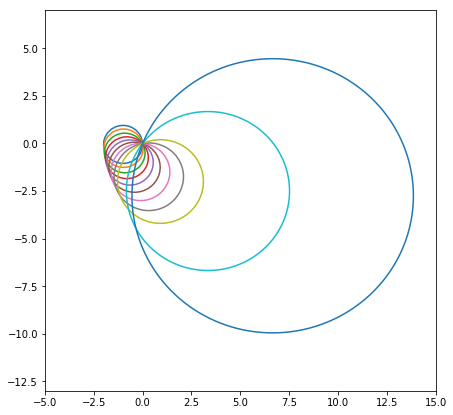

In [55]:
b_1,a_2,b_2 = sp.symbols("b_1 a_2 b_2",real=True)
z = sp.symbols("z",complex=True)
R = sp.Abs(sp.exp(I*b_1) - I*z/b_1*(sp.exp(I*b_1)-1))

save_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [7, 7]
for i,n in enumerate([1,5,10,15,20,25,30,35,40,50,55]):
  contour( R.subs(b_1,n/10.) , z , (-5,15,100) , (-13,7,100) , levels=[1.] , colors=palette[i%len(palette)] )

plt.show()
plt.rcParams['figure.figsize'] = save_figsize

On remarque que le domaine de stabilité évolue en fonction de la valeur de $\lambda = i\texttt{b1}$, ce qui peut paraître normal puisque l'on fait *rentrer* $e^{-\lambda t}$ dans la dérivée temporelle.

Nicolas a poussé l'étude des schémas Runge-Kuta exponentiel aux ordres plus élevés, et on obtient des domaines de stabilités très étranges et surtout asymétriques. C'est l’asymétrie qui nous pose le plus de problème pour l'obtention d'une CFL optimal avec un schéma spatial d'ordre élevé (style WENO).

## 5.2 Schémas de Lawson

Plaçons nous dans un cas plus général que le cas d'opérateurs linéarisés, considérons l'équation suivante :

$$
  \partial_t u = Lu + N(u)
$$

avec $L$ un opérateur linéaire et $N$ un opérateur non-linéaire. On peut écrire une formulation exponentielle de la forme :

$$
  \partial_t \left(e^{-L t}u\right) = e^{-L t}N(u)
$$

Notons $v=e^{-\lambda t}u$, et considérons alors l'opérateur non linéaire $(v,t)\mapsto\tilde{N}(v,t) = e^{-L t}N(e^{L t}v)$ ; l'équation devient, avec ces nouvelles notations :

$$
  \dot{v} = \tilde{N}(v,t)
$$

Équation que l'on peut résoudre à l'aide d'un schéma RK classique, ici le schéma RK SSP(3,3) aussi dit de Shu-Osher :

$$
  \begin{aligned}
    v^{(1)} &= v^n + \Delta t \tilde{N}(v^n,t^n) \\
    v^{(2)} &= \frac{3}{4}v^n + \frac{1}{4}v^{(1)} + \frac{1}{4}\Delta t \tilde{N}(v^{(1)},t^n+\Delta t) \\
    v^{n+1} &= \frac{1}{3}v^n + \frac{2}{3}v^{(2)} + \frac{2}{3}\Delta t \tilde{N}(v^{(2)},t^n+\frac{1}{2}\Delta t) \\
  \end{aligned}
$$

Ce qui nous donne en fonction de $u$ :

$$
  \begin{aligned}
    v^{(1)} &= e^{-L t^n}u^n + \Delta t e^{-L t^n}N(u^n) \\
    v^{(2)} &= \frac{3}{4}e^{-L t^n}u^n + \frac{1}{2}v^{(1)} + \frac{1}{4}\Delta t e^{-Lt^n}e^{-L\Delta t}N(e^{Lt^n}e^{L\Delta t}v^{(1)}) \\
    e^{-L t^n}e^{-L\Delta t}u^{n+1} &= \frac{1}{3}e^{-L t^n}u^n + \frac{2}{3}v^{(2)} + \frac{2}{3}\Delta t e^{-Lt^n}e^{-\frac{1}{2}L\Delta t}N(e^{Lt^n}e^{\frac{1}{2}L\Delta t}v^{(2)})
  \end{aligned}
$$

Pour des raisons purement numériques liées à la précision machine, simplifions dès que possible par $e^{-Lt^n}$ pour s'assurer que le schéma ne dégénère pas en temps long :

$$
  \begin{aligned}
    \tilde{u}^{(1)} &= u^n + \Delta t N(u^n) \\
    \tilde{u}^{(2)} &= \frac{3}{4}u^n + \frac{1}{2}\tilde{u}^{(1)} + \frac{1}{4}\Delta t e^{-L\Delta t}N(e^{L\Delta t}\tilde{u}^{(1)}) \\
    u^{n+1} &= \frac{1}{3}e^{L\Delta t}u^n + \frac{2}{3}e^{L\Delta t}\tilde{u}^{(2)} + \frac{2}{3}\Delta t e^{\frac{1}{2}L\Delta t}N(e^{\frac{1}{2}L\Delta t}\tilde{u}^{(2)})
  \end{aligned}
$$

Les coefficients exponentiels à l'intérieur de l'opérateur non-linéaire nous incitent à poser :

* $u^{(1)} = e^{L\Delta t}\tilde{u}^{(1)}$
* $u^{(2)} = e^{\frac{1}{2}L\Delta t}\tilde{u}^{(2)}$

D'où le schéma suivant :

$$
  \begin{aligned}
    u^{(1)} &= e^{L\Delta t}u^n + \Delta t e^{L\Delta t} N(u^n) \\
    u^{(2)} &= \frac{3}{4}e^{\frac{1}{2}L\Delta t}u^n + \frac{1}{4}e^{-\frac{1}{2}L\Delta t}u^{(1)} + \frac{1}{4}\Delta t e^{-\frac{1}{2}L\Delta t}N(u^{(1)}) \\
    u^{n+1} &= \frac{1}{3}e^{L\Delta t}u^n + \frac{2}{3}e^{\frac{1}{2}L\Delta t}u^{(2)} + \frac{2}{3}\Delta t e^{\frac{1}{2}L\Delta t}N(u^{(2)})
  \end{aligned}
$$

On retrouve ainsi le schéma proposé dans [Isherwood L. et al (2018)](https://github.com/Kivvix/miMaS/blob/master/bibliography/pdf/2018-Isherwood(1).pdf).

Intéressons nous maintenant au domaine de stabilité d'une telle méthode, toujours dans l'approximation que $L=\lambda=ib_1$. On posera $z=\mu \Delta t$.

In [56]:
mu = sp.symbols("\\mu")
def N (u) :
  return mu*u

u1 = sp.exp(lamb*dt)*un + dt*sp.exp(lamb*dt)*N(un)
u2 = sp.Rational(3,4)*sp.exp(sp.Rational(1,2)*lamb*dt)*un + sp.Rational(1,4)*sp.exp(-sp.Rational(1,2)*lamb*dt)*u1 + sp.Rational(1,4)*dt*sp.exp(-sp.Rational(1,2)*lamb*dt)*N(u1)
un1 = sp.Rational(1,3)*sp.exp(lamb*dt)*un + sp.Rational(2,3)*sp.exp(sp.Rational(1,2)*lamb*dt)*u2 + sp.Rational(2,3)*dt*sp.exp(sp.Rational(1,2)*lamb*dt)*N(u2)

un1.subs(mu*dt,z).expand().collect(un).collect(z).collect(sp.exp(dt*lamb))

   ⎛ 3    2        ⎞                  
   ⎜z    z         ⎟  \Delta t⋅\lambda
uₙ⋅⎜── + ── + z + 1⎟⋅ℯ                
   ⎝6    2         ⎠                  

On retrouve le polynôme caractéristique d'un schéma RK SSP(3,3) classique multiplié par $e^{\lambda\Delta t}$. Par conséquent pour $\lambda$ un imaginaire pur, donc de module égal à 1, le domaine de stabilité reste inchangé. On remarque que le cas général $\lambda\in\mathbb{C}$ ou le cas particulier $\lambda\in\mathbb{R}$ (intéressant pour la prise en compte d'un terme de collision BGK par exemple) est plus délicat car le module du polynôme est alors multiplié par $e^{\Delta t \Re(\lambda)}$, qui dépend de $\Delta t$, il ne s'agit donc pas d'une simple homothétie du domaine de stabilité.

In [57]:
plt.rcParams['figure.figsize'] = [6,4] # la valeur par défaut du matplotlib

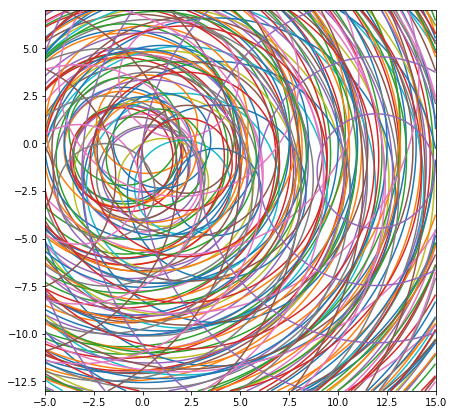

In [58]:
"""
  tentative d'expression artistique
"""

save_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [7, 7]

R = sp.Abs(sp.exp(I*b_1) - I*z/b_1*(sp.exp(I*b_1)-1))
for i,n in enumerate(range(1,56,5)):
  contour( R.subs(b_1,n/10.) , z , (-5,15,100) , (-13,7,100) , colors=palette[i%len(palette)] )
R = sp.Abs(sp.exp(I*b_1) - I*z/b_1*(sp.exp(-I*b_1)-1))
for i,n in enumerate(range(1,56,8)):
  contour( R.subs(b_1,n/10.) , z , (-5,15,100) , (-13,7,100) , colors=palette[i%len(palette)] )
R = sp.Abs(sp.exp(I*b_1) - I*z/b_1*(sp.exp(I*b_1)+1))
for i,n in enumerate(range(1,56,7)):
  contour( R.subs(b_1,n/10.) , z , (-5,15,100) , (-13,7,100) , colors=palette[i%len(palette)] )

plt.show()
plt.rcParams['figure.figsize'] = save_figsize

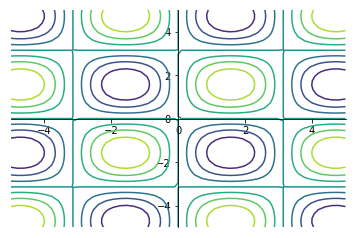

In [59]:
from sympy.plotting.plot import plot_contour
plot_contour(sp.sin(a_2)*sp.sin(b_2), (a_2, -5, 5), (b_2, -5, 5))

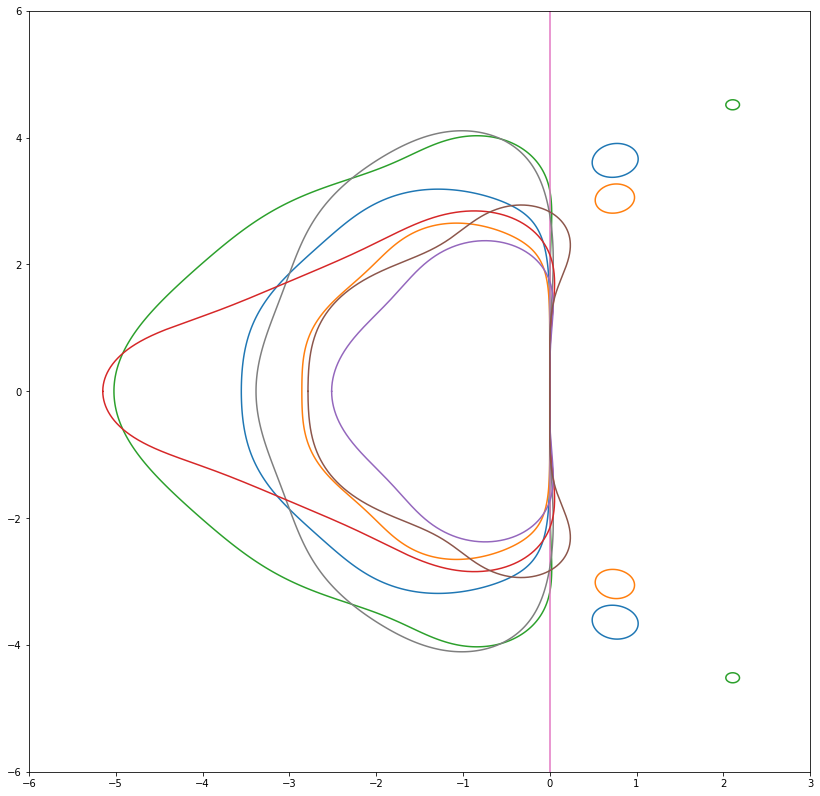

In [60]:
save_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [14, 14]

R = sp.Abs(poly_carac(6))
contour(R,z,(-6.,3.,500),(-6.,6.,500), levels=[1.],colors=palette[0])
R = sp.Abs(prk6_7)
contour(R,z,(-6.,3.,500),(-6.,6.,500), levels=[1.],colors=palette[1])
R = sp.Abs(prk6_8)
contour(R,z,(-6.,3.,500),(-6.,6.,500), levels=[1.],colors=palette[2])
plt.plot(*reim(b34),label="ERK SSP(4,3)",color=palette[3])
plt.plot(*reim(b3),label="ERK SSP(3,3)",color=palette[4])
plt.plot(*reim(b4),label="ERK SSP(4,4)",color=palette[5])
R = sp.Abs((z+1)/(z-1))
contour(R,z,(-6.,3.,500),(-6.,6.,500), levels=[1.],colors=palette[6])
R = sp.Abs(prk3_5)
contour(R,z,(-6.,3.,500),(-6.,6.,500), levels=[1.],colors=palette[7])
plt.show()
plt.rcParams['figure.figsize'] = save_figsize